# <center>Predictive Modeling of Under-5 Mortality Determinants in Kenya Using KDHS 2022 Data

---

## Business Understanding
Under-5 mortality remains a major public health challenge in Kenya. Although progress has been made, child deaths before the age of five still contribute significantly to preventable mortality. In 2023, sub-Saharan Africa recorded the highest under-5 mortality rate at **74 deaths per 1000 live births** (WHO, 2024).  

The key problem this project seeks to address is:  
**What demographic, socioeconomic, and environmental factors most influence under-5 mortality in Kenya, and can we predict individual or community-level risk using machine learning?**

This topic is highly relevant because reducing under-5 mortality is central to Kenya’s progress toward **Sustainable Development Goal (SDG) 3 – Good Health and Well-being**. Specifically, **SDG target 3.2** aims to end preventable deaths of newborns and children under 5 years by 2030 (WHO, n.d.).  

The project sits at the intersection of **public health and data science**, with a target audience that includes:  
- Policymakers  
- Public health agencies  
- NGOs and implementing partners  
- Academic researchers  

If successful, this work could:  
- Provide actionable insights on high-risk populations  
- Support targeted interventions (e.g., immunization, nutrition, maternal health services)  
- Guide equitable resource allocation  
- Ultimately reduce preventable child deaths  

While previous research has used DHS data with **logistic regression and survival analysis**, this project will extend the literature by applying **predictive supervised machine learning** (e.g., Random Forest, Gradient Boosting), emphasizing both **accuracy** and **interpretability** to inform health policy.

---

## Data Understanding
The dataset will be the **2022 Kenya Demographic and Health Survey (KDHS)**, obtained through The DHS Program upon approval. It is a nationally representative household survey covering fertility, maternal and child health, mortality, socioeconomic conditions, and health service utilization.  

**Target variable:** Under-5 mortality (death of a child before reaching the age of five).  

**Features of interest include:**  
- **Maternal characteristics**: age, education, parity, antenatal care visits  
- **Child characteristics**: sex of child, birth interval, birth order, place of delivery, immunization status  
- **Household characteristics**: wealth index, access to water and sanitation, household size  
- **Geographic/Environmental factors**: region, rural vs. urban residence, environmental exposures  
- **Healthcare utilization**: vaccination coverage, access to healthcare services  

Previous DHS-based studies have primarily been descriptive or inferential. This project will build upon them by creating a **predictive framework** that identifies patterns of risk in under-5 mortality, making results more actionable for public health interventions.

---

## Data Preparation
The DHS datasets are provided in **CSV, Stata and SPSS formats** (`.csv`, `.dta`, `.sav`) and will be imported into **Python**. The data include a mix of **categorical** and **numerical** variables.  

**Preprocessing steps will include:**  
- Handling missing values (e.g., imputation strategies)  
- Recoding categorical variables 
- Deriving new features (e.g., age groups, birth intervals, maternal age at first birth)  
- Balancing outcome classes (since child survival is far more common than child death)  
- Normalizing or standardizing numeric inputs where appropriate  
- Applying DHS sample weights to account for complex survey design  

**Challenges anticipated:**  
- Complex survey design (stratification, clustering, weighting)  
- Class imbalance (rare event prediction problem)  
- Variable coding complexity (DHS uses numeric codes that require careful recoding)  

**Data visualisation plans:**  
- Descriptive statistics (means, medians, proportions by outcome)  
- Mortality rates by region, wealth quintile, maternal education, and other key factors  
- Distribution plots comparing children who survived vs. those who died before age five  
- Correlation heatmaps for potential multicollinearity among predictors  


# <center>Exploratory Data Analysis

In [2]:
# Import libraries
import pyreadstat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import plotly.express as px
import pickle
from scipy import stats
import scipy.stats as ss
from scipy.stats import pointbiserialr


In [639]:
# View file contents
df, meta = pyreadstat.read_sas7bdat('KEKR8CFL.SAS7BDAT')
df.head()

,CASEID,BIDX,V000,V001,V002,V003,V004,V005,V006,V007,...,S621B,S626Q,S626R,S626S,S626T,S631A,S631B,S631C,S631L,S631M
0,1 4 2,1.0,KE8,1.0,4.0,2.0,1.0,1296049.0,4.0,2022.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1 13 2,1.0,KE8,1.0,13.0,2.0,1.0,1296049.0,4.0,2022.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1 26 2,1.0,KE8,1.0,26.0,2.0,1.0,1296049.0,4.0,2022.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1 42 1,1.0,KE8,1.0,42.0,1.0,1.0,1296049.0,4.0,2022.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1 55 2,1.0,KE8,1.0,55.0,2.0,1.0,1296049.0,4.0,2022.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [640]:
#load, open and view the map file with the full descriptions of the variables
with open('KEKR8CFL.MAP', 'r', encoding="ISO-8859-1") as file:
    sas_code = file.read()
    print(sas_code)

                                                   KEKR8CFL                                                   
                                                KEKR8CFL_DICT                                                 

                                             KEKR8CFL.DCF                                                     
                                    Last Modified:  8/12/2024  1:03:00 PM                                     

--------------------------------------------------------------------------------------------------------------
Level Name                    Level Label                                                  Type            Rec
  Record Name                   Record Label                                              Value  Req  Max  Len
--------------------------------------------------------------------------------------------------------------
HOUSEHOLD                     HOUSEHOLD                                                                       

In [641]:
# Select variables
under5_vars = [
    'CASEID','V012','V024','V025','V106','V130','V131','V136','V190','V161','V206','V207',
    'V445','BORD','B4','B5','B7','B11','B12','B20',
    'M13','M14','M15','M18','M19','M2A','M2B','M2G', 'M2H',

    #Vaccination Variables
    'B3',
    'H1A', 'H10', 'H69', 'S528A',
    'H2', 'H2D', 'H2M', 'H2Y', 
    'H4', 'H4D', 'H4M', 'H4Y',
    'H6', 'H6D', 'H6M', 'H6Y',
    'H8', 'H8D', 'H8M', 'H8Y',
    'H0', 'H0D', 'H0M', 'H0Y',
    'H9', 'H9D', 'H9M', 'H9Y',
    'H9A', 'H9AD', 'H9AM', 'H9AY',
    'H51', 'H51D', 'H51M', 'H51Y',
    'H52', 'H52D', 'H52M', 'H52Y',
    'H53', 'H53D', 'H53M', 'H53Y',
    'H54', 'H54D', 'H54M', 'H54Y',
    'H55', 'H55D', 'H55M', 'H55Y',
    'H56', 'H56D', 'H56M', 'H56Y',
    'H57', 'H57D', 'H57M', 'H57Y',
    'H58', 'H58D', 'H58M', 'H58Y',
    'H60', 'H60D', 'H60M', 'H60Y',

    #Nutrition Variables
    'V404', 'M4', 'M5',
    'M19A',
    'M34', 'M55', 'HW1',
    'HW2', 'HW3',
    'HW70', 'HW71', 'HW72',

    #Illness / Exposure Variables
    'S621A',

    #WASH / Household Environment Variables
    'V113',
    'V127', 'V465',

    #Healthcare Access Variables
    'V394', 'V417',
    'V467D', 'V483A', 'V483B',
    'M1', 'M1A',
    'M3A', 'M3B', 'M3G', 'M3H',
    'S446']

df = df[under5_vars]

In [642]:
#rename the columns for easier understanding
df = df.rename(columns = {
    'CASEID': 'CASEID',
    'V012': 'Respondents current age',
    'V024': 'Region',
    'V025': 'Type of place of residence',
    'V106': 'Highest educational level',
    'V115': 'Time to get to water source',
    'V130': 'Religion',
    'V131': 'Ethnicity',
    'V136': 'Number of household members',
    'V190': 'Wealth index combined',
    'V161': 'Type of cooking fuel',
    'V206': 'Sons who have died',
    'V207': 'Daughters who have died',
    'V445': 'Respondents Body Mass Index',
    'BORD': 'Birth order number',
    'B3': 'Date of birth (CMC)',
    'B4': 'Sex of child',
    'B5': 'Child is alive',
    'B7': 'Age at death (months, imputed)', 
    'B11': 'Preceding birth interval (months)',
    'B12': 'Succeeding birth interval (months)',
    'B20': 'Duration of pregnancy in months',
    'M13': 'Timing of 1st antenatal check (months)',
    'M14': 'Number of antenatal visits during pregnancy',
    'M15': 'Place of delivery',
    'M18': 'Size of child at birth',
    'M19': 'Birth weight in kilograms (3 decimals)',
    'M2A':  'Prenatal: doctor',
    'M2B':  'Prenatal: nurse/midwife/clinical officer',
    'M2G': 'Prenatal: traditional birth attendant',
    'M2H': 'Prenatal: Community health worker/field worker',
    'H1A': 'Has health card and or other vaccination document',
    'H2': 'Received BCG',
    'H2D': 'BCG day',
    'H2M': 'BCG month',
    'H2Y': 'BCG year',
    'H4': 'Received POLIO 1',
    'H4D': 'POLIO 1 day',
    'H4M': 'POLIO 1 month',
    'H4Y': 'POLIO 1 year',
    'H6': 'Received POLIO 2',
    'H6D': 'POLIO 2 day',
    'H6M': 'POLIO 2 month',
    'H6Y': 'POLIO 2 year',
    'H8': 'Received POLIO 3',
    'H8D': 'POLIO 3 day',
    'H8M': 'POLIO 3 month',
    'H8Y': 'POLIO 3 year',
    'H0': 'Received POLIO 0',
    'H0D': 'POLIO 0 day',
    'H0M': 'POLIO 0 month',
    'H0Y': 'POLIO 0 year',
    'H9': 'Received MEASLES 1',
    'H9D': 'Measles 1 day',
    'H9M': 'Measles 1 month',
    'H9Y': 'Measles 1 year',
    'H9A': 'Received MEASLES 2',
    'H9AD': 'Measles 2 day',
    'H9AM': 'Measles 2 month',
    'H9AY': 'Measles 2 year',
    'H60': 'Received inactivated polio (IPV)',
    'H60D': 'Inactivated polio (IPV) day',
    'H60M': 'Inactivated polio (IPV) month',
    'H60Y': 'Inactivated polio (IPV) year',
    'H10': 'Ever had vaccination',
    'H51': 'Received Pentavalent 1',
    'H51D': 'Pentavalent 1 day',
    'H51M': 'Pentavalent 1 month',
    'H51Y': 'Pentavalent 1 year',
    'H52': 'Received Pentavalent 2',
    'H52D': 'Pentavalent 2 day',
    'H52M': 'Pentavalent 2 month',
    'H52Y': 'Pentavalent 2 year',
    'H53': 'Received Pentavalent 3',
    'H53D': 'Pentavalent 3 day',
    'H53M': 'Pentavalent 3 month',
    'H53Y': 'Pentavalent 3 year',
    'H54': 'Received Pneumococcal 1',
    'H54D': 'Pneumococcal 1 day',
    'H54M': 'Pneumococcal 1 month',
    'H54Y': 'Pneumococcal 1 year',
    'H55': 'Received Pneumococcal 2',
    'H55D': 'Pneumococcal 2 day',
    'H55M': 'Pneumococcal 2 month',
    'H55Y': 'Pneumococcal 2 year',
    'H56': 'Received Pneumococcal 3',
    'H56D': 'Pneumococcal 3 day',
    'H56M': 'Pneumococcal 3 month',
    'H56Y': 'Pneumococcal 3 year',
    'H57': 'Received Rotavirus 1',
    'H57D': 'Rotavirus 1 day',
    'H57M': 'Rotavirus 1 month',
    'H57Y': 'Rotavirus 1 year',
    'H58': 'Received Rotavirus 2',
    'H58D': 'Rotavirus 2 day',
    'H58M': 'Rotavirus 2 month',
    'H58Y': 'Rotavirus 2 year',
    'H69': 'Place where most vaccinations were received',
    'H10': 'Ever had vaccination',
    'S528A': 'Yellow fever vaccine',
    'V404': 'Currently breastfeeding',
    'M4': 'Duration of breastfeeding',
    'M5': 'Months of breastfeeding',
    'M19A': 'Weight at birth/recall',
    'M34': 'When child put to breast',
    'M55': 'Given child anything other than breast milk',
    'HW1': 'Childs age in months',
    'HW2': 'Childs weight in kilograms (1 decimal)',
    'HW3': 'Childs height in centimeters (1 decimal)',
    'HW70': 'Height/Age standard deviation (new WHO)',
    'HW71': 'Weight/Age standard deviation (new WHO)',
    'HW72': 'Weight/Height standard deviation (new WHO)',
    'S621A': 'In contact with someone with cough or TB',
    'V113': 'Source of drinking water',
    'V127': 'Main floor material',
    'V465': 'Disposal of youngest childs stools',
    'V394': 'Visited health facility last 12 months',
    'V417': 'Entries in pregnancy and postnatal care roster',
    'V467D': 'Getting medical help for self: distance to health facility',
    'V483A': 'Minutes to nearest healthcare facility',
    'V483B': 'Mode of transportation to nearest healthcare facility',
    'M1': 'Number of tetanus injections before birth',
    'M1A': 'Number of tetanus injections before pregnancy',
    'M3A': 'Assistance: doctor',
    'M3B': 'Assistance: nurse/midwife/clinical officer',
    'M3H': 'Assistance: Relative/friend',
    'M3G': 'Assistance: traditional birth attendant',
    'S446': 'Respondent treated with respect at facility'
})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19530 entries, 0 to 19529
Columns: 126 entries, CASEID to Respondent treated with respect at facility
dtypes: float64(125), object(1)
memory usage: 18.8+ MB


In [643]:
# Check duplicates
print("Number of duplicate rows:", df.duplicated().sum())

# Check basic stats for numeric columns
display(df.describe())

Number of duplicate rows: 0


,Respondents current age,Region,Type of place of residence,Highest educational level,Religion,Ethnicity,Number of household members,Wealth index combined,Type of cooking fuel,Sons who have died,...,Getting medical help for self: distance to health facility,Minutes to nearest healthcare facility,Mode of transportation to nearest healthcare facility,Number of tetanus injections before birth,Number of tetanus injections before pregnancy,Assistance: doctor,Assistance: nurse/midwife/clinical officer,Assistance: traditional birth attendant,Assistance: Relative/friend,Respondent treated with respect at facility
count,19530.000000,19530.000000,19530.000000,19530.000000,19530.000000,19530.000000,19530.000000,19530.000000,19530.000000,19530.000000,...,10267.000000,10267.000000,10267.000000,10412.000000,6805.000000,11728.000000,11728.000000,11728.000000,11728.000000,4405.000000
mean,29.167588,23.497542,1.657655,1.324322,5.404813,20.560471,5.869688,2.637481,9.443625,0.100256,...,1.682283,43.744619,20.783286,1.268248,1.772814,0.415331,0.585351,0.119628,0.060198,1.166402
std,6.591613,13.707384,0.474507,0.972344,13.509171,33.306912,2.588980,1.449923,15.195492,0.345390,...,0.465611,57.925473,5.195579,0.919682,1.859749,0.492800,0.492682,0.324540,0.237863,0.459294
min,15.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,24.000000,10.000000,1.000000,1.000000,2.000000,4.000000,4.000000,1.000000,7.000000,0.000000,...,1.000000,15.000000,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,28.000000,24.000000,2.000000,1.000000,3.000000,7.000000,5.000000,3.000000,8.000000,0.000000,...,2.000000,30.000000,24.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,34.000000,35.000000,2.000000,2.000000,7.000000,11.000000,7.000000,4.000000,8.000000,0.000000,...,2.000000,60.000000,24.000000,2.000000,3.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,49.000000,47.000000,2.000000,3.000000,96.000000,96.000000,24.000000,5.000000,97.000000,5.000000,...,2.000000,600.000000,96.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [644]:
# Calculate missing values per column
missing_data = (
    df.isnull().sum()  # count of missing values per column
    .to_frame("missing_count")  # convert to DataFrame
    .assign(missing_pct=lambda x: 100 * x["missing_count"] / len(df))  # calculate percentage
    .sort_values("missing_pct", ascending=False)  # sort descending by missing %
)

# Display the top 15 columns with the most missing values
missing_data.head(60)

,missing_count,missing_pct
"Age at death (months, imputed)",18836,96.446493
Measles 2 day,17529,89.754224
Measles 2 month,17529,89.754224
Measles 2 year,17529,89.754224
Yellow fever vaccine,16686,85.437788
Ever had vaccination,16176,82.826421
Respondent treated with respect at facility,15125,77.444956
Measles 1 year,14903,76.308244
Measles 1 day,14903,76.308244
Measles 1 month,14903,76.308244


In [645]:
# Define the 3 target variables for EDA
df['neonatal_death'] = df.apply(
    lambda x: 1 if (x['Child is alive'] == 0 and pd.notnull(x['Age at death (months, imputed)']) and x['Age at death (months, imputed)'] < 1) else 0,
    axis=1
)
df['infant_death'] = df.apply(
    lambda x: 1 if (x['Child is alive'] == 0 and pd.notnull(x['Age at death (months, imputed)']) and x['Age at death (months, imputed)'] < 12) else 0,
    axis=1
)
df['under5_death'] = df.apply(
    lambda x: 1 if (x['Child is alive'] == 0 and pd.notnull(x['Age at death (months, imputed)']) and x['Age at death (months, imputed)'] < 60) else 0,
    axis=1
)

#safely skips missing or invalid ages

# Confirmation of the above
df[['neonatal_death', 'infant_death', 'under5_death']].sum()

neonatal_death    437
infant_death      617
under5_death      694
dtype: int64

In [646]:
# Create a survival category
df['death_category'] = np.select(
    [
        df['neonatal_death'] == 1,
        df['infant_death'] == 1,
        df['under5_death'] == 1
    ],
    ['Neonatal death', 'Infant death', 'Under-5 death'],
    default='Alive'
)

# Sanity check
df['death_category'].value_counts(normalize=True).mul(100).round(2)

death_category
Alive             96.45
Neonatal death     2.24
Infant death       0.92
Under-5 death      0.39
Name: proportion, dtype: float64

In [647]:
# Master mapping dictionary: keys = column names, values = mapping dicts
mappings = {
    "Region": {1:"Mombasa",2:"Kwale",3:"Kilifi",4:"Tana River",5:"Lamu",6:"Taita Taveta",7:"Garissa",8:"Wajir",9:"Mandera",10:"Marsabit",
               11:"Isiolo",12:"Meru",13:"Tharaka-Nithi",14:"Embu",15:"Kitui",16:"Machakos",17:"Makueni",18:"Nyandarua",19:"Nyeri",20:"Kirinyaga",
               21:"Murang'a",22:"Kiambu",23:"Turkana",24:"West Pokot",25:"Samburu",26:"Trans Nzoia",27:"Uasin Gishu",28:"Elgeyo-Marakwet",
               29:"Nandi",30:"Baringo",31:"Laikipia",32:"Nakuru",33:"Narok",34:"Kajiado",35:"Kericho",36:"Bomet",37:"Kakamega",38:"Vihiga",
               39:"Bungoma",40:"Busia",41:"Siaya",42:"Kisumu",43:"Homa Bay",44:"Migori",45:"Kisii",46:"Nyamira",47:"Nairobi"},
    "Type of place of residence": {1:"Urban", 2:"Rural"},
    "Highest educational level": {0:"No education",1:"Primary",2:"Secondary",3:"Higher",9:"Missing"},
    "Religion": {1:"Catholic",2:"Protestant",3:"Evangelical churches",4:"African instituted churches",5:"Orthodox",
                 6:"Other Christian",7:"Islam",8:"Hindu",9:"Traditionists",10:"No religion/atheists",96:"Other",99:"Missing"},
    "Ethnicity": {1:"Embu",2:"Kalenjin",3:"Kamba",4:"Kikuyu",5:"Kisii",6:"Luhya",7:"Luo",8:"Maasai",9:"Meru",10:"Mijikenda/Swahili",
                  11:"Somali",12:"Taita/Taveta",96:"Other",99:"Missing"},
    "Wealth index combined": {1:"Poorest",2:"Poorer",3:"Middle",4:"Richer",5:"Richest"},
    "Type of cooking fuel": {1:"Electricity",2:"LPG",3:"Natural gas",4:"Biogas",5:"Kerosene",6:"Coal, lignite",7:"Charcoal",8:"Wood",
                     9:"Straw/shrubs/grass",10:"Agricultural crop",11:"Animal dung",12:"Alcohol/ethanol",13:"Gasoline/diesel",14:"Solar Power",96:"Other",97:"Not a dejure resident",99:"Missing"},
    "Sex of child": {1:"Male",2:"Female"},
    "Place of delivery": {10:"HOME",11:"Respondent's home",12:"Other home",20:"PUBLIC SECTOR",21:"Government hospital",
                       22:"Government health center",23:"Government dispensary",26:"Other public sector",30:"PRIVATE MEDICAL SECTOR",
                       31:"Private hospital",32:"Private clinic",36:"Other private medical sector",40:"NGO SECTOR",41:"NGO hospital",
                       42:"NGO clinic",43:"FBO/mission hospital",44:"FBO/mission clinic",46:"Other NGO medical sector",47:"Other FBO medical sector",96:"Other",99:"Missing"},
    "Size of child at birth": {1:"Very large",2:"Larger than average",3:"Average",4:"Smaller than average",5:"Very small",8:"Don't Know",9:"Missing"},
    "Has health card and or other vaccination document": {0:"Does not have either card or other document",1:"Has only health card and was seen",
                                                         2:"Has only health card and wasn't seen",3:"Has only other document and was seen",
                                                         4:"Has only other document and wasn't seen",5:"Has card/other document but only card was seen",
                                                         6:"Has card/other document but only other document was seen",7:"Has card/other document and both were seen",
                                                         8:"Has card/other document and none were seen",99:"Missing"},
    "Place where most vaccinations were received": {10:"PUBLIC SECTOR",11:"Government hospital",12:"Government health center",13:"Government dispensary",
                                                   14:"Mobile clinic",15:"Community health worker/fieldworker",16:"Other public health sector",
                                                   20:"PRIVATE MEDICAL SECTOR",21:"Private hospital",22:"Private clinic",23:"Pharmacy",
                                                   24:"Private doctor",25:"Private mobile clinic",26:"Private community health worker/fieldworker",
                                                   27:"Other private medical sector",30:"NGO MEDICAL SECTOR",31:"NGO hospital",32:"NGO clinic",
                                                   33:"FBO/mission hospital",34:"FBO/mission clinic",35:"FBO mobile clinic",36:"Other NGO medical sector",
                                                   37:"Other FBO sector",40:"OTHER SOURCE",41:"Vaccination campaign",98:"Don't know",99:"Missing"},
    "Ever had vaccination": {0:"No",1:"Yes",8:"Don't know",9:"Missing"},
    "Yellow fever vaccine": {0:"No",1:"Yes",8:"Don't know",9:"Missing"},
    "Currently breastfeeding": {0:"No",1:"Yes"},
    "Given child anything other than breast milk": {0:"No",1:"Yes",9:"Missing"},
    "In contact with someone with cough or TB": {0:"No",1:"Yes",8:"Don't know"},
    "Source of drinking water": {10:"PIPED WATER",11:"Piped into dwelling",12:"Piped to yard/plot",13:"Piped to neighbor",14:"Public tap/standpipe",
                                 20:"TUBE WELL WATER",21:"Tube well or borehole",30:"DUG WELL (OPEN/PROTECTED)",31:"Protected well",32:"Unprotected well",
                                 40:"SURFACE FROM SPRING",41:"Protected spring",42:"Unprotected spring",43:"River/dam/lake/ponds/stream/canal/irrigation channel",
                                 51:"Rainwater",61:"Tanker truck",62:"Cart with small tank",71:"Bottled water",96:"Other",97:"Not a dejure resident",99:"Missing"},
    "Main floor material": {10:"NATURAL",11:"Earth/sand",12:"Dung",20:"RUDIMENTARY",21:"Wood planks",22:"Palm/bamboo",30:"FINISHED",
                            31:"Parquet or polished wood",32:"Vinyl or asphalt strips",33:"Ceramic tiles",34:"Cement",35:"Carpet",96:"Other",97:"Not a dejure resident",99:"Missing"},
    "Visited health facility last 12 months": {0:"No",1:"Yes",9:"Missing"},
    "Getting medical help for self: distance to health facility": {0:"No problem",1:"Big problem",2:"Not a big problem",9:"Missing"},
    "Mode of transportation to nearest healthcare facility": {11:"Car/truck",12:"Public bus",13:"Motorcycle/scooter",14:"Boat with motor",15:"Other motorized",
                                                        16:"Other motorized",17:"Other motorized",18:"Other motorized",19:"Other motorized",
                                                        21:"Animal-drawn cart",22:"Bicycle",23:"Boat without motor",24:"Walking",
                                                        25:"Other not motorized",26:"Other not motorized",27:"Other not motorized",28:"Other not motorized",
                                                        29:"Other not motorized",96:"Other",99:"Missing"}
}

# Vaccine columns (all share the same mapping)
vaccine_cols = ["Received BCG","Received POLIO 1","Received POLIO 2","Received POLIO 3","Received POLIO 0",
                "Received MEASLES 1","Received MEASLES 2","Received inactivated polio (IPV)","Received Pentavalent 1",
                "Received Pentavalent 2","Received Pentavalent 3","Received Pneumococcal 1","Received Pneumococcal 2",
                "Received Pneumococcal 3","Received Rotavirus 1","Received Rotavirus 2"]

vaccine_mapping = {0:"No",1:"Vaccination date on card",2:"Reported by mother",3:"Vaccination marked on card",8:"Don't know"}

# Apply all mappings in a loop
for col, mapping in mappings.items():
    df[col] = df[col].map(mapping)

# Map vaccines separately
for col in vaccine_cols:
    df[col] = df[col].map(vaccine_mapping)


In [648]:
# Create a dataframe copy for EDA only
df_eda = df.copy()

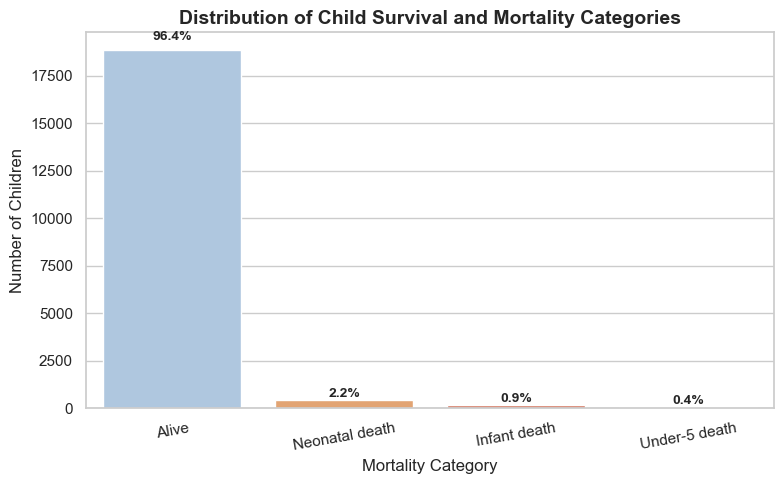

In [649]:
# Mortlity plots
sns.set(style="whitegrid", palette="Set2")

# Compute counts and percentages
death_counts = df_eda['death_category'].value_counts().reset_index()
death_counts.columns = ['Category', 'Count']
death_counts['Percentage'] = (death_counts['Count'] / death_counts['Count'].sum()) * 100

# Logical category order
order = ['Alive', 'Neonatal death', 'Infant death', 'Under-5 death']
death_counts['Category'] = pd.Categorical(death_counts['Category'], categories=order, ordered=True)
death_counts = death_counts.sort_values('Category')

# Create the plot (assign hue=x and disable legend)
plt.figure(figsize=(8, 5))
bar = sns.barplot(
    data=death_counts,
    x='Category',
    y='Count',
    hue='Category',
    order = death_counts.sort_values('Count', ascending=False)['Category'],              
    palette=['#A7C7E7', '#F4A261', '#E76F51', '#2A9D8F'],
    legend=False                  
)

# Add labels above bars
for i, row in death_counts.iterrows():
    plt.text(i, row['Count'] + (row['Count'] * 0.02),
             f"{row['Percentage']:.1f}%", ha='center', va='bottom',
             fontsize=10, fontweight='bold')

# Titles and labels
plt.title("Distribution of Child Survival and Mortality Categories", fontsize=14, weight='bold')
plt.xlabel("Mortality Category", fontsize=12)
plt.ylabel("Number of Children", fontsize=12)

plt.xticks(rotation=10)
plt.tight_layout()
plt.show()


## Core descriptive and demographic EDA

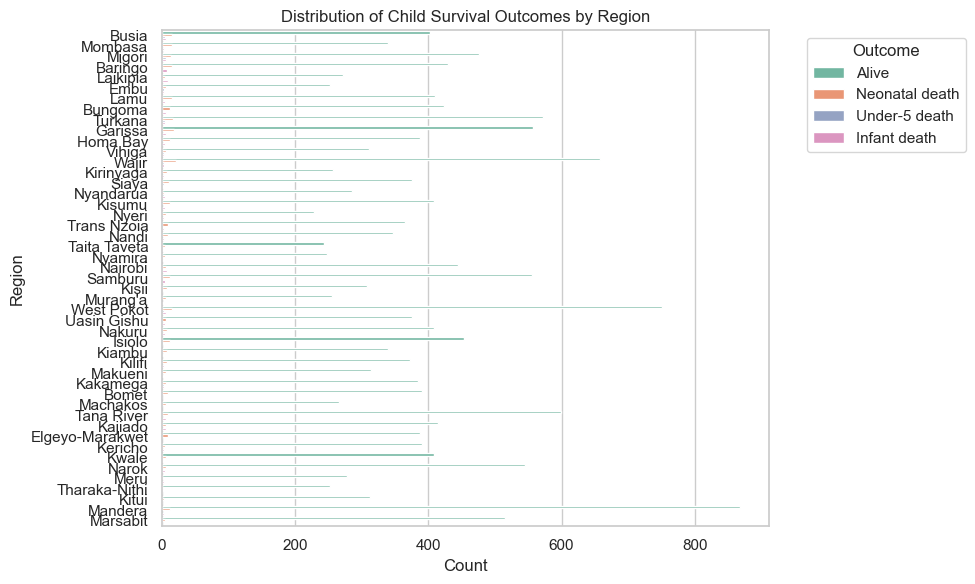

In [650]:
# Mortality by region

# Sort regions by total deaths for clearer plots
region_order = (
    df_eda.groupby('Region')['death_category']
    .apply(lambda x: (x != 'Alive').mean())
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_eda,
    y='Region',
    hue='death_category',
    order=region_order,
    palette='Set2'
)
plt.title('Distribution of Child Survival Outcomes by Region')
plt.xlabel('Count')
plt.ylabel('Region')
plt.legend(title='Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [651]:
region_deaths = (
    df_eda.groupby('Region')['under5_death']
    .mean() * 100  # mean() of 1/0 gives proportion
).reset_index(name='Under-5 Mortality Rate (%)')

region_deaths.head()


,Region,Under-5 Mortality Rate (%)
0,Baringo,5.286344
1,Bomet,2.977667
2,Bungoma,4.729730
3,Busia,6.074766
4,Elgeyo-Marakwet,2.518892


In [652]:
fig = px.bar(
    region_deaths,
    x='Under-5 Mortality Rate (%)',
    y='Region',
    color='Under-5 Mortality Rate (%)',
    color_continuous_scale='Reds',
    title='Under-5 Mortality Rate by County (Interactive)',
    height=900
)

# Sort regions by mortality rate for clarity
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    xaxis_title='Under-5 Mortality Rate (%)',
    yaxis_title='County',
    template='plotly_white'
)

fig.show()


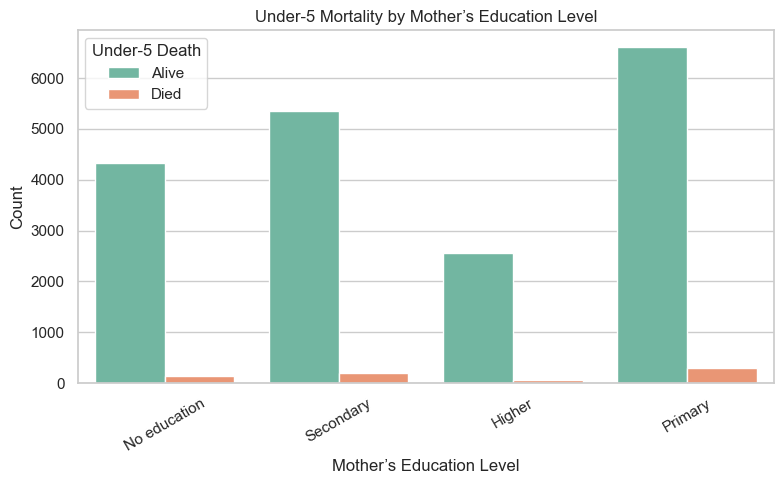

In [653]:
plt.figure(figsize=(8,5))
sns.countplot(data=df_eda, x='Highest educational level', hue='under5_death', palette='Set2')
plt.title('Under-5 Mortality by Mother’s Education Level')
plt.xlabel('Mother’s Education Level')
plt.ylabel('Count')
plt.legend(title='Under-5 Death', labels=['Alive', 'Died'])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


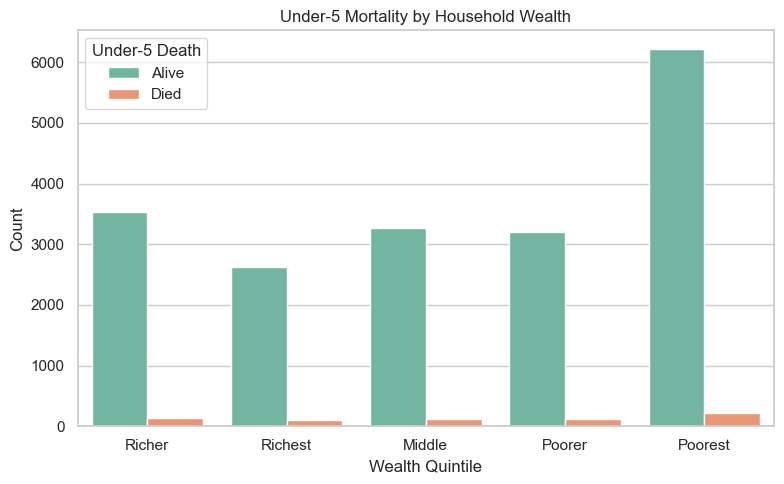

In [654]:
plt.figure(figsize=(8,5))
sns.countplot(data=df_eda, x='Wealth index combined', hue='under5_death', palette='Set2')
plt.title('Under-5 Mortality by Household Wealth')
plt.xlabel('Wealth Quintile')
plt.ylabel('Count')
plt.legend(title='Under-5 Death', labels=['Alive', 'Died'])
plt.tight_layout()
plt.show()


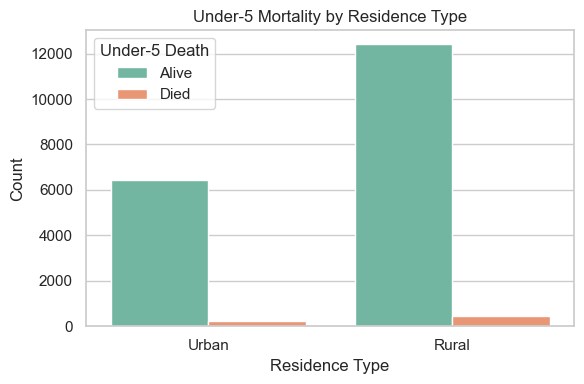

In [655]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_eda, x='Type of place of residence', hue='under5_death', palette='Set2')
plt.title('Under-5 Mortality by Residence Type')
plt.xlabel('Residence Type')
plt.ylabel('Count')
plt.legend(title='Under-5 Death', labels=['Alive', 'Died'])
plt.tight_layout()
plt.show()


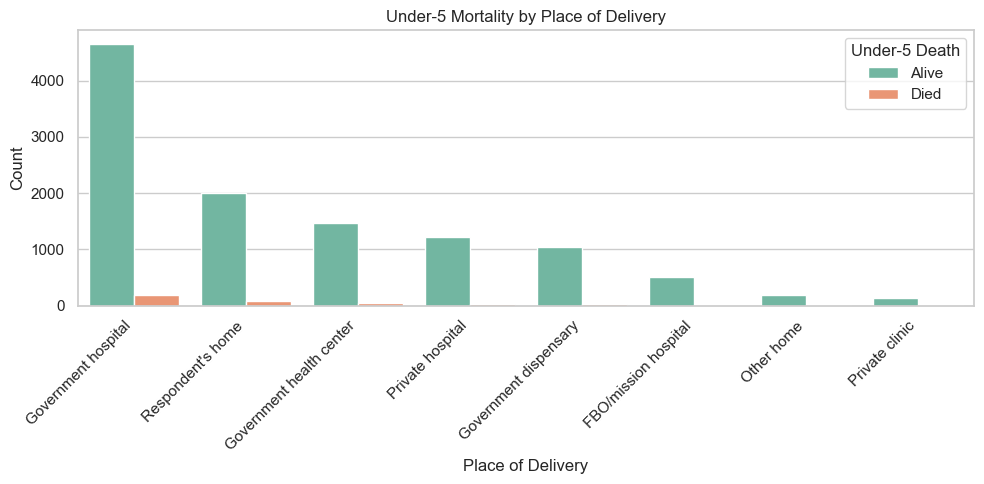

In [656]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_eda, x='Place of delivery', hue='under5_death', palette='Set2',
              order=df_eda['Place of delivery'].value_counts().index[:8])  # top 8 categories
plt.title('Under-5 Mortality by Place of Delivery')
plt.xlabel('Place of Delivery')
plt.ylabel('Count')
plt.legend(title='Under-5 Death', labels=['Alive', 'Died'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


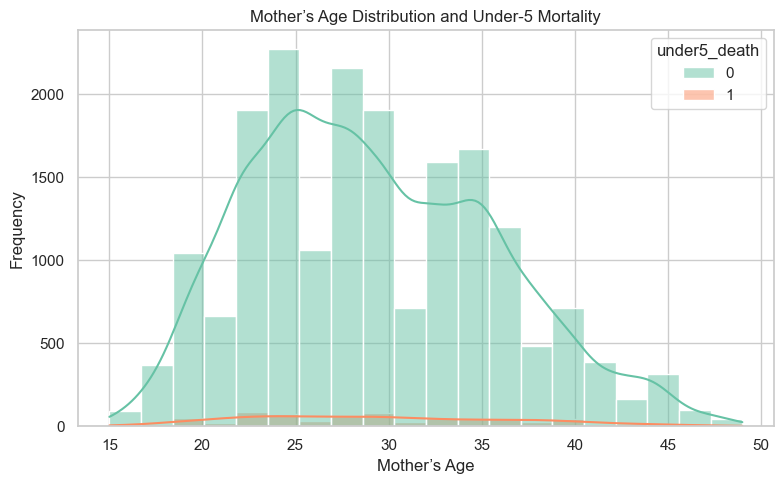

In [657]:
plt.figure(figsize=(8,5))
sns.histplot(data=df_eda, x='Respondents current age', hue='under5_death', kde=True, palette='Set2', bins=20)
plt.title('Mother’s Age Distribution and Under-5 Mortality')
plt.xlabel('Mother’s Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## Child-Related and Household Predictors

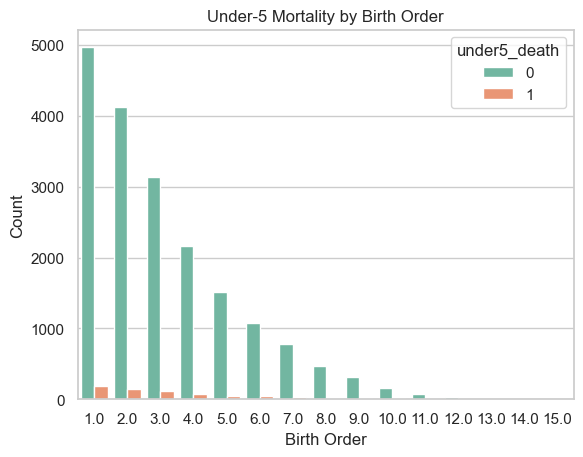

In [658]:
sns.countplot(data=df_eda, x='Birth order number', hue='under5_death', palette='Set2')
plt.title('Under-5 Mortality by Birth Order')
plt.xlabel('Birth Order')
plt.ylabel('Count')
plt.show()


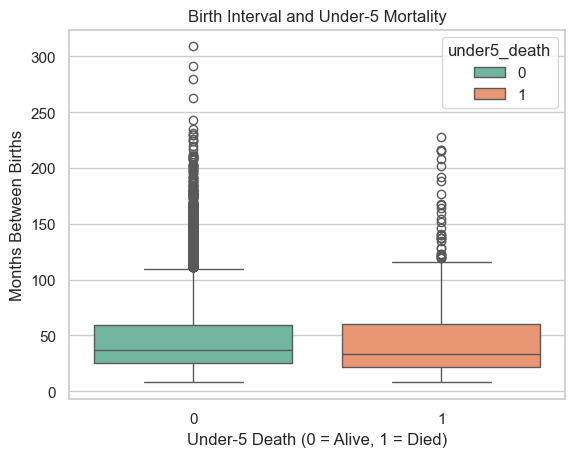

In [659]:
sns.boxplot(data=df_eda, x='under5_death', y='Preceding birth interval (months)', palette='Set2', hue = 'under5_death')
plt.title('Birth Interval and Under-5 Mortality')
plt.xlabel('Under-5 Death (0 = Alive, 1 = Died)')
plt.ylabel('Months Between Births')
plt.show()


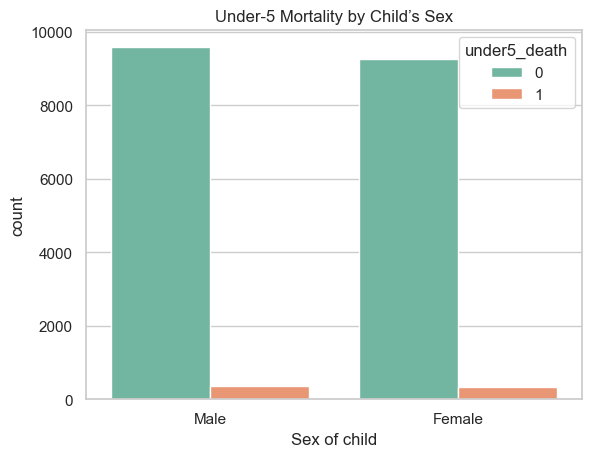

In [660]:
sns.countplot(data=df_eda, x='Sex of child', hue='under5_death', palette='Set2')
plt.title('Under-5 Mortality by Child’s Sex')
plt.show()


In [661]:
# Distribution of maternal BMI by child survival status (alive vs died)

# Categorize maternal BMI

# Drop missing BMI values
bmi_df = df_eda[['Respondents Body Mass Index', 'Child is alive']].dropna()

# Convert BMI to numeric (if not already)
bmi_df['Respondents Body Mass Index'] = pd.to_numeric(bmi_df['Respondents Body Mass Index'], errors='coerce')

# DHS usually stores BMI * 100 — check if mean > 1000 to rescale
if bmi_df['Respondents Body Mass Index'].mean() > 100:
    bmi_df['Respondents Body Mass Index'] = bmi_df['Respondents Body Mass Index'] / 100

# Create BMI categories
bmi_df['BMI Category'] = pd.cut(
    bmi_df['Respondents Body Mass Index'],
    bins=[0, 18.5, 25, 30, 60],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese']
)


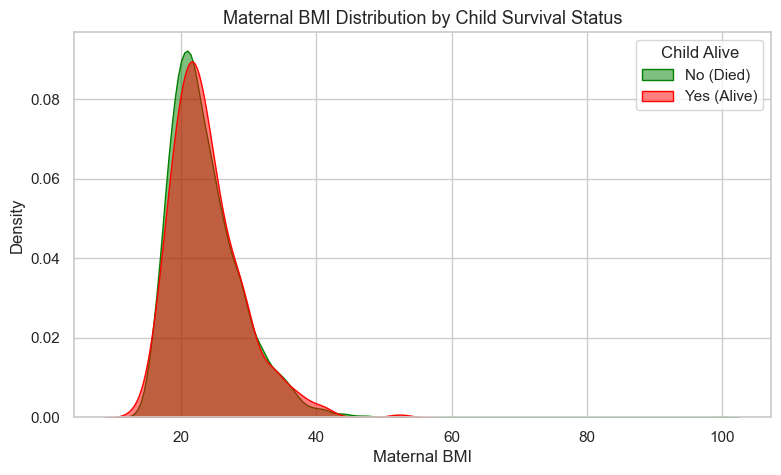

In [662]:
# Distribution of maternal BMI by child survival status
plt.figure(figsize=(9, 5))
sns.kdeplot(
    data=bmi_df,
    x='Respondents Body Mass Index',
    hue='Child is alive',
    fill=True,
    common_norm=False,
    palette=['red', 'green'],
    alpha=0.5
)
plt.title('Maternal BMI Distribution by Child Survival Status', fontsize=13)
plt.xlabel('Maternal BMI')
plt.ylabel('Density')
plt.legend(title='Child Alive', labels=['No (Died)', 'Yes (Alive)'])
plt.show()


- If curves overlap heavily, BMI alone may not explain much variation in under-5 mortality.

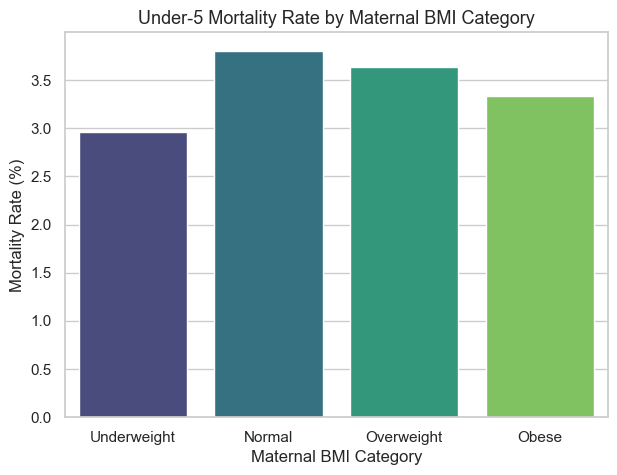

,BMI Category,Under-5 Mortality Rate (%)
0,Underweight,2.959831
1,Normal,3.806228
2,Overweight,3.636364
3,Obese,3.330487


In [663]:
# Under-5 mortality rate by BMI category
bmi_summary = (
    bmi_df.groupby('BMI Category', observed=True)['Child is alive']
    .apply(lambda x: 100 * (1 - x.mean()))
    .reset_index(name='Under-5 Mortality Rate (%)')
)

plt.figure(figsize=(7, 5))
sns.barplot(
    data=bmi_summary,
    x='BMI Category',
    y='Under-5 Mortality Rate (%)',
    hue='BMI Category',      # added hue to avoid palette warning
    palette='viridis',
    legend=False
)
plt.title('Under-5 Mortality Rate by Maternal BMI Category', fontsize=13)
plt.ylabel('Mortality Rate (%)')
plt.xlabel('Maternal BMI Category')
plt.show()

bmi_summary


## Environmental Factors and Under-5 Mortality

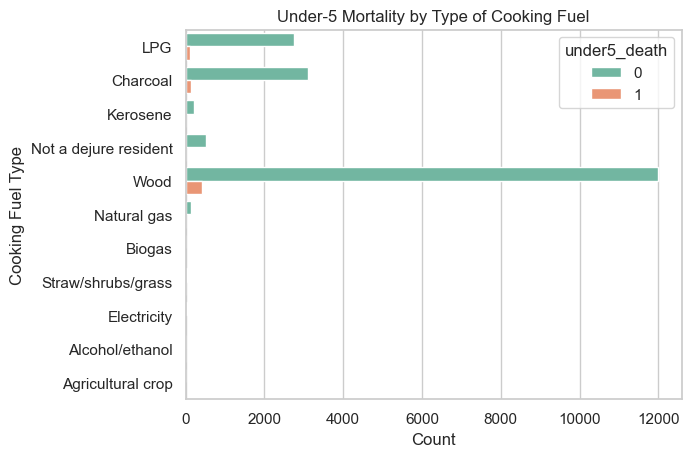

In [664]:
# Type of Cooking Fuel
sns.countplot(
    data=df_eda,
    y='Type of cooking fuel',
    hue='under5_death',
    palette='Set2'
)
plt.title('Under-5 Mortality by Type of Cooking Fuel')
plt.xlabel('Count')
plt.ylabel('Cooking Fuel Type')
plt.show()


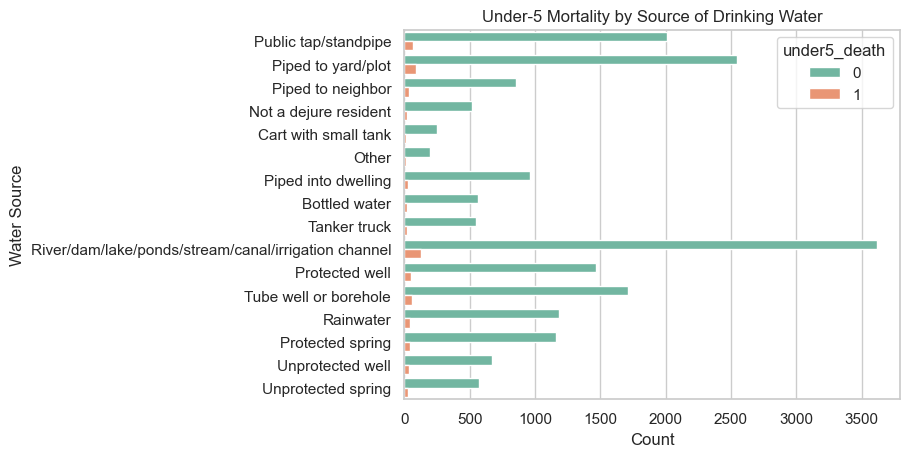

In [665]:
# Source of Drinking Water
sns.countplot(
    data=df_eda,
    y='Source of drinking water',
    hue='under5_death',
    palette='Set2'
)
plt.title('Under-5 Mortality by Source of Drinking Water')
plt.xlabel('Count')
plt.ylabel('Water Source')
plt.show()


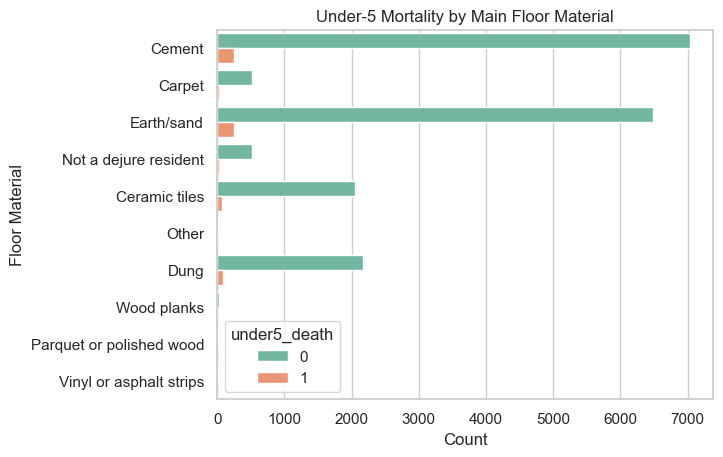

In [666]:
# Main Floor Material
sns.countplot(
    data=df_eda,
    y='Main floor material',
    hue='under5_death',
    palette='Set2'
)
plt.title('Under-5 Mortality by Main Floor Material')
plt.xlabel('Count')
plt.ylabel('Floor Material')
plt.show()


In [667]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19530 entries, 0 to 19529
Columns: 130 entries, CASEID to death_category
dtypes: float64(87), int64(3), object(40)
memory usage: 19.4+ MB


# <center>Data Cleaning and Feature Engineering

In [668]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19530 entries, 0 to 19529
Columns: 130 entries, CASEID to death_category
dtypes: float64(87), int64(3), object(40)
memory usage: 19.4+ MB


### Handle Special Missing Values

In [669]:
def handle_missing_values(df):
    """
    Clean missing and placeholder values after mapping.
    1. Replaces numeric placeholders (99, 9999, etc.) with NaN in numeric columns.
    2. Replaces string placeholders ('Missing', "Don't know") with NaN in all columns.
    """

    # Replace numeric placeholder codes
    special_missing_values = {
        9, 99, 999, 9999, 99999, 999999, 9999999,
        8, 98, 998, 9998, 99998,
        7, 97, 997, 9997, 99997,
        6, 96, 996, 9996, 99996
    }

    for col in df.select_dtypes(include=["float64", "int64"]).columns:
        df[col] = df[col].replace(special_missing_values, np.nan)

    # Replace string placeholders
    string_missing_values = [
        "Missing", "Don't know", "Dont know", "Unknown", "Not stated",
        "Not a dejure resident", "Other (specify)"
    ]

    df = df.replace(string_missing_values, np.nan)

    return df

df = handle_missing_values(df)

In [670]:
## when child is put to breast
def clean_breastfeeding_time(x):
    if pd.isna(x): 
        return np.nan
    if x == 0:        # immediately
        return 0
    if x == 100:      # within first hour
        return 0.5    # or keep as 0 to mean <1 hour
    if 101 <= x <= 198:  # hours
        return x - 100
    if x == 199:
        return np.nan
    if x == 201:      # days:1
        return 24
    if 202 <= x <= 298:
        return (x - 200) * 24
    if x == 299:
        return np.nan

df['When child put to breast'] = df['When child put to breast'].apply(clean_breastfeeding_time)

In [671]:
def clean_months_breastfeeding(x):
    if pd.isna(x):
        return np.nan
    if 0 <= x <= 59:       # actual months
        return x
    if x == 93:            # ever breastfed, not currently
        return np.nan      # or 60 if you want to flag “>59”
    if x == 94:            # never breastfed
        return 0           # or np.nan if you prefer to handle separately
    return np.nan          # catch any unexpected value

df['Months of breastfeeding'] = df['Months of breastfeeding'].apply(clean_months_breastfeeding)

In [672]:
def clean_height_age_z(x):
    if pd.isna(x):
        return np.nan
    if -600 <= x <= 600:        # valid range, stored x100
        return x / 100.0
    return np.nan               # any unexpected code

df['Height/Age standard deviation (new WHO)'] = df['Height/Age standard deviation (new WHO)'].apply(clean_height_age_z)

def clean_who_z(x, lower=-600, upper=500):
    """Convert WHO z-score×100 to float and replace special codes with NaN."""
    if pd.isna(x):
        return np.nan
    if lower <= x <= upper:      # valid numeric value
        return x / 100.0
    return np.nan               # any other unexpected code

df['Weight/Age standard deviation (new WHO)'] = df['Weight/Age standard deviation (new WHO)'].apply(clean_who_z)
df['Weight/Height standard deviation (new WHO)'] = df['Weight/Height standard deviation (new WHO)'].apply(clean_who_z)

In [673]:
col = 'Birth weight in kilograms (3 decimals)'

df[col] = df[col].apply(
    lambda x: x / 1000 if pd.notnull(x) and x > 10 else x
)

In [674]:
# Create a binary flag for child death history
df["child_death_history"] = (
    ((df["Sons who have died"] > 0) | (df["Daughters who have died"] > 0))
    .astype(int))

In [675]:
def classify_prenatal(row):
    if all(pd.isna(row[col]) for col in [
        'Prenatal: doctor', 'Prenatal: nurse/midwife/clinical officer',
        'Prenatal: traditional birth attendant', 'Prenatal: Community health worker/field worker'
    ]):
        return np.nan

    if any(row[col] == 1 for col in ['Prenatal: doctor', 'Prenatal: nurse/midwife/clinical officer']):
        return "Skilled"
    elif any(row[col] == 1 for col in ['Prenatal: traditional birth attendant', 'Prenatal: Community health worker/field worker']):
        return "Unskilled"
    else:
        return "Unknown"


def classify_delivery(row):
    if all(pd.isna(row[col]) for col in [
        'Assistance: doctor', 'Assistance: nurse/midwife/clinical officer',
        'Assistance: traditional birth attendant', 'Assistance: Relative/friend'
    ]):
        return np.nan

    if any(row[col] == 1 for col in ['Assistance: doctor', 'Assistance: nurse/midwife/clinical officer']):
        return "Skilled"
    elif any(row[col] == 1 for col in ['Assistance: traditional birth attendant', 'Assistance: Relative/friend']):
        return "Unskilled"
    else:
        return "Unknown"

df['prenatal_help'] = df.apply(classify_prenatal, axis=1)
df['delivery_help'] = df.apply(classify_delivery, axis=1)


### Reworking the Vaccination Variables

In [676]:
# Create a helper function to convert vaccination date into CMC (Century Month Code)
def to_cmc(year, month):
    """Convert DHS year+month into CMC (Century Month Code)."""
    if pd.isna(year) or pd.isna(month):
        return np.nan
    if year in [9997, 9998, 9999] or month in [97, 98, 99]:
        return np.nan
    return (int(year) - 1900) * 12 + int(month)


In [677]:
# Create a function to compute vaccination age 
def compute_vaccine_age(df, vaccine_name, birth_col="Date of birth (CMC)"):
    year_col = f"{vaccine_name} year"
    month_col = f"{vaccine_name} month"
    age_col = f"{vaccine_name}_age_months"
    
    def compute_age(row):
        birth_cmc = row[birth_col]
        vax_cmc = to_cmc(row[year_col], row[month_col])
        if pd.isna(birth_cmc) or pd.isna(vax_cmc):
            return np.nan
        age = vax_cmc - birth_cmc
        # filter out impossible (negative) ages
        if age < 0:
            return np.nan
        return age
    
    df[age_col] = df.apply(compute_age, axis=1)
    return df

In [678]:
# List of vaccines with date info
vaccine_names = [
    "BCG", "POLIO 0", "POLIO 1", "POLIO 2", "POLIO 3",
    "Pentavalent 1", "Pentavalent 2", "Pentavalent 3",
    "Pneumococcal 1", "Pneumococcal 2", "Pneumococcal 3",
    "Rotavirus 1", "Rotavirus 2",
    "Inactivated polio (IPV)",
    "Measles 1", "Measles 2"
]

# Apply compute_vaccine_age to each
for v in vaccine_names:
    df = compute_vaccine_age(df, v, birth_col="Date of birth (CMC)")

In [679]:
## Categorize Vaccination Timelines
def categorize_timeliness(age, recommended, lower, upper):
    """
    Categorize vaccination timeliness.
    
    age: observed vaccination age (in months)
    recommended: recommended target age (months)
    lower, upper: acceptable on-time window
    """
    if pd.isna(age):
        return "missing"
    elif age < lower:
        return "early"
    elif lower <= age <= upper:
        return "on_time"
    else:
        return "delayed"

# Define recommended schedule (months)
schedule = {
    "BCG": (0, 0, 1),
    "POLIO 0": (0, 0, 1),
    "POLIO 1": (1.5, 1, 2),
    "Pentavalent 1": (1.5, 1, 2),
    "Pneumococcal 1": (1.5, 1, 2),
    "Rotavirus 1": (1.5, 1, 2),
    "POLIO 2": (2.5, 2, 3),
    "Pentavalent 2": (2.5, 2, 3),
    "Pneumococcal 2": (2.5, 2, 3),
    "Rotavirus 2": (2.5, 2, 3),
    "POLIO 3": (3.5, 3, 5),
    "Pentavalent 3": (3.5, 3, 5),
    "Pneumococcal 3": (3.5, 3, 5),
    "Inactivated polio (IPV)": (3.5, 3, 5),
    "Measles 1": (9, 9, 12),
    "Measles 2": (15, 15, 18)
}

In [680]:
# Generate timeliness columns
new_cols = {}

for v, (rec, low, high) in schedule.items():
    age_col = f"{v}_age_months"
    time_col = f"{v}_timeliness"
    new_cols[time_col] = df[age_col].apply(lambda x: categorize_timeliness(x, rec, low, high))

# Add all new columns at once
df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)


In [681]:
# Summarize the timeliness of all vaccines
def summarize_timeliness(df, vaccine_codes):
    summary = {}
    
    for v in vaccine_codes:
        col = v + "_timeliness"
        if col in df.columns:
            counts = df[col].value_counts(dropna=False)
            proportions = df[col].value_counts(normalize=True, dropna=False) * 100
            summary[v] = pd.DataFrame({
                "Count": counts,
                "Proportion (%)": proportions.round(1)
            })
            print(f"\n{v} timeliness distribution")
            print(summary[v])
    return summary

# Run and Print
summary_tables = summarize_timeliness(df, vaccine_names)


BCG timeliness distribution
                Count  Proportion (%)
BCG_timeliness                       
missing         14335            73.4
on_time          4878            25.0
delayed           317             1.6

POLIO 0 timeliness distribution
                    Count  Proportion (%)
POLIO 0_timeliness                       
missing             15193            77.8
on_time              4235            21.7
delayed               102             0.5

POLIO 1 timeliness distribution
                    Count  Proportion (%)
POLIO 1_timeliness                       
missing             14603            74.8
on_time              4532            23.2
delayed               294             1.5
early                 101             0.5

POLIO 2 timeliness distribution
                    Count  Proportion (%)
POLIO 2_timeliness                       
missing             14819            75.9
on_time              4209            21.6
delayed               438             2.2
early     

In [682]:
# Example printout
df['BCG_age_months'].describe()
df['BCG_age_months'].value_counts().sort_index().head(20)

BCG_age_months
0.0     3833
1.0     1045
2.0      175
3.0       59
4.0       23
5.0       16
6.0        8
7.0        4
8.0        3
9.0        3
10.0       1
11.0       2
12.0      16
13.0       1
14.0       2
15.0       1
24.0       1
25.0       2
Name: count, dtype: int64

In [683]:
# Define function for dropping columns with too many missing values
def safe_drop(df, cols_to_drop):
    """
    Drop columns safely:
    - Ignores duplicates and missing columns.
    - Also drops any column ending with '_age_months', 'day', 'month', or 'year'.
    """
    cols_to_drop = list(set(cols_to_drop))  # unique

    # Dynamic matches
    drop_patterns = ("_age_months", " day", " month", " year")
    pattern_cols = [
        col for col in df.columns
        if any(col.lower().endswith(p) for p in drop_patterns)
    ]
    
    cols_to_drop.extend(pattern_cols)

    # Keep only those that exist
    cols_to_drop = [col for col in cols_to_drop if col in df.columns]
    
    return df.drop(columns=cols_to_drop)


# Updated columns list with readable variable names
cols = [
    'Child is alive',
    'Sons who have died',
    'Daughters who have died',
    'Duration of pregnancy in months',
    'Childs age in months',
    'Age at death (months, imputed)',
    'Prenatal: doctor',
    'Prenatal: nurse/midwife/clinical officer',
    'Prenatal: traditional birth attendant',
    'Prenatal: Community health worker/field worker',
    'Assistance: doctor',
    'Assistance: nurse/midwife/clinical officer',
    'Assistance: traditional birth attendant',
    'Assistance: Relative/friend',

    # Birth & vaccine variables (renamed from DHS codes)
    'Date of birth (CMC)',
    'Received BCG',
    'Received POLIO 0', 'Received POLIO 1', 'Received POLIO 2', 'Received POLIO 3',
    'Received DPT 1', 'Received DPT 2', 'Received DPT 3',
    'Received Pentavalent 1', 'Received Pentavalent 2', 'Received Pentavalent 3',
    'Received Pneumococcal 1', 'Received Pneumococcal 2', 'Received Pneumococcal 3',
    'Received Rotavirus 1', 'Received Rotavirus 2',
    'Received MEASLES 1', 'Received MEASLES 2',
    'Received inactivated polio (IPV)',

    # Too many missing values and redundant variables
    'Respondent treated with respect at facility',
    'Disposal of youngest childs stools',
    'During pregnancy took: SP/fansidar for malaria',
    'Weight at birth/recall',
    'Duration of breastfeeding',
    'Succeeding birth interval (months)',
    'Timing of 1st antenatal check (months)',
    'Number of antenatal visits during pregnancy',
    'Size of child at birth',
    'Birth weight in kilograms (3 decimals)',
    'Ever had vaccination',
    'Yellow fever vaccine',
    'Months of breastfeeding',
    'When child put to breast',
    'Given child anything other than breast milk',
    'Number of tetanus injections before pregnancy'
]

# Apply drop
df = safe_drop(df, cols)

In [684]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19530 entries, 0 to 19529
Data columns (total 55 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   CASEID                                                      19530 non-null  object 
 1   Respondents current age                                     19530 non-null  float64
 2   Region                                                      19530 non-null  object 
 3   Type of place of residence                                  19530 non-null  object 
 4   Highest educational level                                   19530 non-null  object 
 5   Religion                                                    19530 non-null  object 
 6   Ethnicity                                                   19530 non-null  object 
 7   Number of household members                                 11937 non-null  float64
 

In [685]:
# Calculate missing values per column
missing_data = (
    df.isnull().sum()  # count of missing values per column
    .to_frame("missing_count")  # convert to DataFrame
    .assign(missing_pct=lambda x: 100 * x["missing_count"] / len(df))  # calculate percentage
    .sort_values("missing_pct", ascending=False)  # sort descending by missing %
)

# Display the top 15 columns with the most missing values
missing_data.head(15)

,missing_count,missing_pct
Respondents Body Mass Index,9359,47.921147
Minutes to nearest healthcare facility,9309,47.665131
Getting medical help for self: distance to health facility,9263,47.429595
Mode of transportation to nearest healthcare facility,9263,47.429595
Visited health facility last 12 months,9262,47.424475
Number of tetanus injections before birth,9158,46.891961
prenatal_help,9118,46.687148
Place where most vaccinations were received,8744,44.772145
Has health card and or other vaccination document,8188,41.925243
Place of delivery,7803,39.953917


In [686]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# --- Numeric columns: fill missing values with median
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# --- Categorical columns: fill missing values with mode (first value)
for col in categorical_cols:
    mode_val = df[col].mode(dropna=True)
    if not mode_val.empty:
        df[col] = df[col].fillna(mode_val[0])
    else:
        df[col] = df[col].fillna('Unknown')


In [687]:
# Calculate missing values per column
missing_data = (
    df.isnull().sum()  # count of missing values per column
    .to_frame("missing_count")  # convert to DataFrame
    .assign(missing_pct=lambda x: 100 * x["missing_count"] / len(df))  # calculate percentage
    .sort_values("missing_pct", ascending=False)  # sort descending by missing %
)

# Display the top 15 columns with the most missing values
missing_data.head(15)

,missing_count,missing_pct
CASEID,0,0.0
Respondents current age,0,0.0
Region,0,0.0
Type of place of residence,0,0.0
Highest educational level,0,0.0
Religion,0,0.0
Ethnicity,0,0.0
Number of household members,0,0.0
Wealth index combined,0,0.0
Type of cooking fuel,0,0.0


In [688]:
# Make a safe working copy
df = df.copy()

# Object ID
df['CASEID'] = df['CASEID'].astype('object')

# Continuous floats
float_vars = [
    'Childs weight in kilograms (1 decimal)',
    'Childs height in centimeters (1 decimal)',
    'Height/Age standard deviation (new WHO)',
    'Weight/Age standard deviation (new WHO)',
    'Weight/Height standard deviation (new WHO)'
]
df[float_vars] = df[float_vars].apply(pd.to_numeric, errors="coerce").astype('float64')

# Discrete ints (nullable safe type)
int_vars = [
    'Number of household members',
    'Birth order number',
    'Preceding birth interval (months)',
    'Entries in pregnancy and postnatal care roster',
    'Minutes to nearest healthcare facility',
    'Number of tetanus injections before birth'
]
df[int_vars] = df[int_vars].apply(pd.to_numeric, errors="coerce").astype('int64')

# Categorical (nominal/ordinal)
cat_vars = [
    'Region',
    'Type of place of residence',
    'Highest educational level',
    'Religion',
    'Ethnicity',
    'Wealth index combined',
    'Type of cooking fuel',
    'Sex of child',
    'Place of delivery',
    'Has health card and or other vaccination document',
    'Place where most vaccinations were received',
    'Currently breastfeeding',
    'In contact with someone with cough or TB',
    'Source of drinking water',
    'Main floor material',
    'Visited health facility last 12 months',
    'Getting medical help for self: distance to health facility',
    'Mode of transportation to nearest healthcare facility',
    'delivery_help',
    'prenatal_help',
    'child_death_history',

    # --- Updated timeliness fields ---
    'BCG_timeliness',
    'POLIO 0_timeliness',
    'POLIO 1_timeliness',
    'POLIO 2_timeliness',
    'POLIO 3_timeliness',
    'Pentavalent 1_timeliness',
    'Pentavalent 2_timeliness',
    'Pentavalent 3_timeliness',
    'Pneumococcal 1_timeliness',
    'Pneumococcal 2_timeliness',
    'Pneumococcal 3_timeliness',
    'Rotavirus 1_timeliness',
    'Rotavirus 2_timeliness',
    'Inactivated polio (IPV)_timeliness',
    'Measles 1_timeliness',
    'Measles 2_timeliness'
]

df[cat_vars] = df[cat_vars].astype('category')

In [689]:
# Save full dataframe
with open("u5mr_dataset.pkl", "wb") as f:
    pickle.dump(df, f)

print(f"Saved essential subset with {df.shape[1]} variables and {df.shape[0]} rows.")

Saved essential subset with 55 variables and 19530 rows.


# <center>Statistical Analysis
## Correlation plots

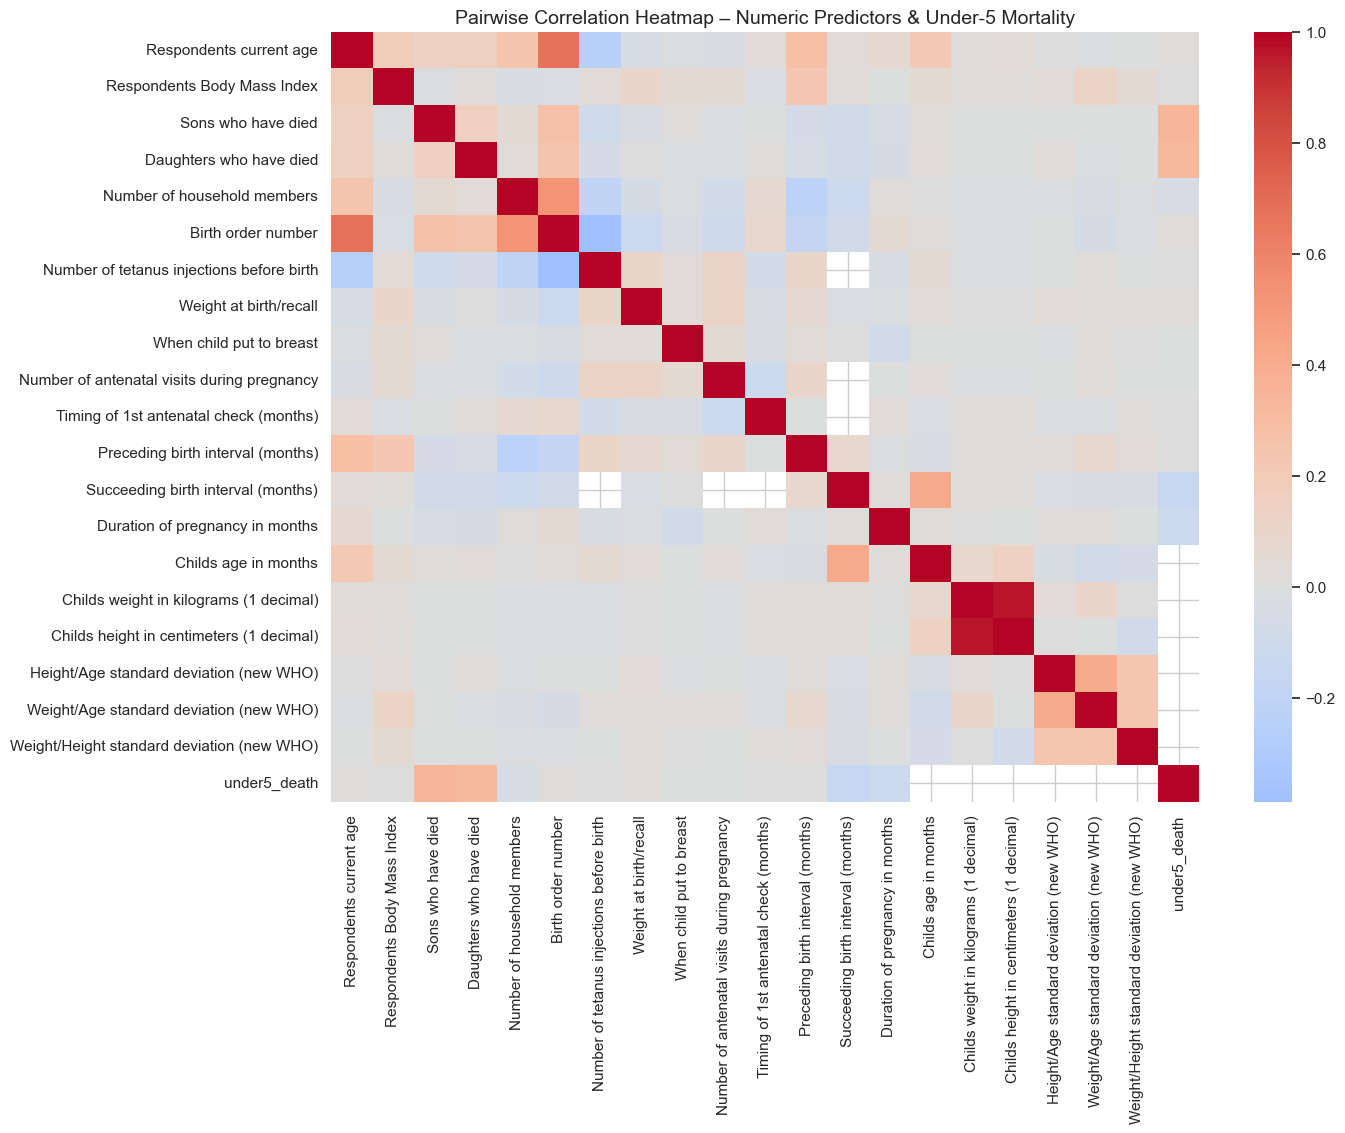

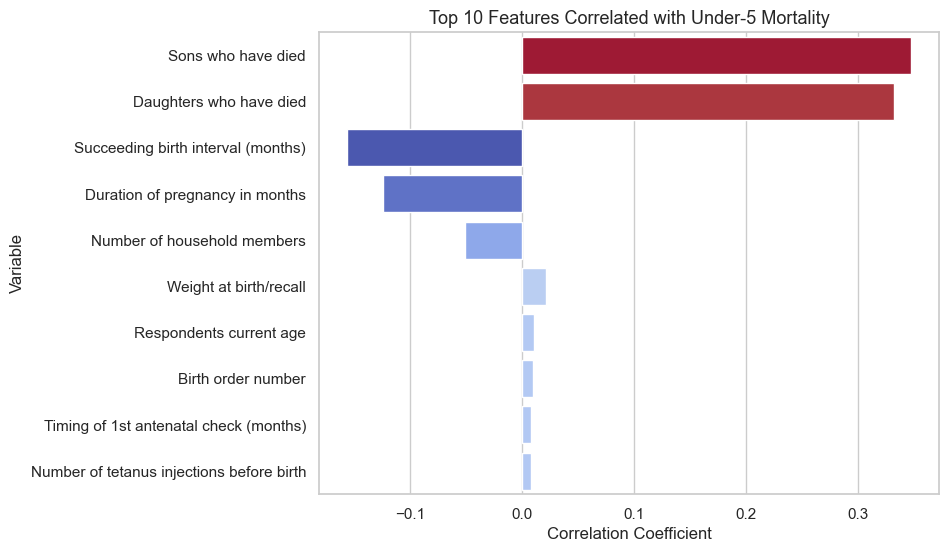

Sons who have died                           0.348
Daughters who have died                      0.332
Succeeding birth interval (months)          -0.156
Duration of pregnancy in months             -0.124
Number of household members                 -0.051
Weight at birth/recall                       0.021
Respondents current age                      0.011
Birth order number                           0.010
Timing of 1st antenatal check (months)       0.008
Number of tetanus injections before birth    0.008
Name: under5_death, dtype: float64


In [690]:
# Subset relevant numeric variables 
cols_to_keep = [
    'Respondents current age',
    'Respondents Body Mass Index',
    'Sons who have died',
    'Daughters who have died',
    'Number of household members',
    'Birth order number',
    'Number of tetanus injections before birth',
    'Weight at birth/recall',
    'When child put to breast',
    'Number of antenatal visits during pregnancy',
    'Timing of 1st antenatal check (months)',
    'Preceding birth interval (months)',
    'Succeeding birth interval (months)',
    'Duration of pregnancy in months',
    'Childs age in months',
    'Childs weight in kilograms (1 decimal)',
    'Childs height in centimeters (1 decimal)',
    'Height/Age standard deviation (new WHO)',
    'Weight/Age standard deviation (new WHO)',
    'Weight/Height standard deviation (new WHO)',
    'under5_death'
]

# Extract numeric subset (ignore missing values per pair)
corr_df = df_eda[cols_to_keep]

# Compute pairwise correlation matrix 
corr_matrix = corr_df.corr(method='pearson', min_periods=100)

# Correlation heatmap 
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title("Pairwise Correlation Heatmap – Numeric Predictors & Under-5 Mortality", fontsize=14)
plt.show()

# Focused plot: strongest correlations with under5_death
# Drop self-correlation and sort by absolute strength
under5_corr = (
    corr_matrix['under5_death']
    .drop('under5_death')
    .dropna()
    .sort_values(key=abs, ascending=False)
)

# Take top 10 absolute correlations
top_corr = under5_corr.head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm', hue = top_corr.values, legend = False)
plt.title("Top 10 Features Correlated with Under-5 Mortality", fontsize=13)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Variable")
plt.show()

# Optional: print the exact correlation values
print(top_corr.round(3))


In [691]:
# Categorical associations

# Select categorical features of interest
cat_cols = [
    'Region',
    'Type of place of residence',
    'Highest educational level',
    'Religion',
    'Ethnicity',
    'Place of delivery',
    'Wealth index combined',
    'under5_death'
]

cat_df = df_eda[cat_cols].dropna()


In [692]:
# Define a function for Cramér’s V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))
    rcorr = r - ((r - 1)**2)/(n - 1)
    kcorr = k - ((k - 1)**2)/(n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


In [693]:
# Compute Cramér’s V for each categorical variable vs. target
cramer_results = {}

for col in cat_df.columns:
    if col != 'under5_death':
        cramer_results[col] = cramers_v(cat_df[col], cat_df['under5_death'])

cramer_df = pd.DataFrame.from_dict(cramer_results, orient='index', columns=['Cramér’s V'])
cramer_df.sort_values('Cramér’s V', ascending=False)


,Cramér’s V
Place of delivery,0.038748
Region,0.025286
Highest educational level,0.021155
Type of place of residence,0.000000
Religion,0.000000
Ethnicity,0.000000
Wealth index combined,0.000000


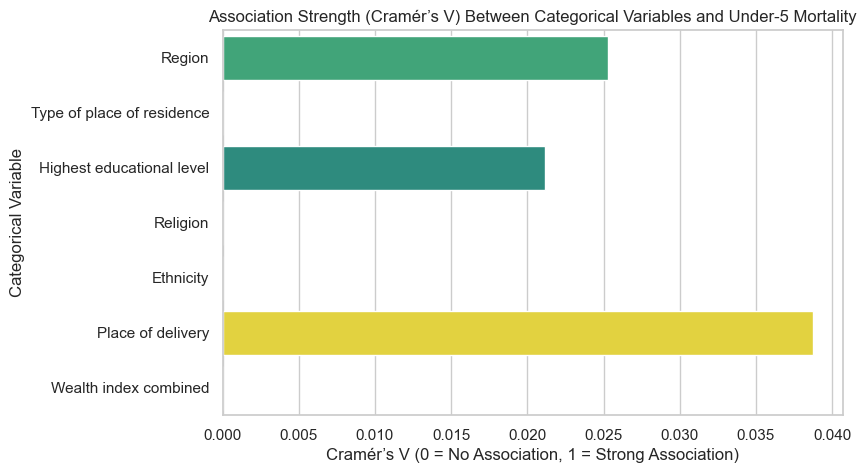

In [694]:
# Plot the results
plt.figure(figsize=(8, 5))
sns.barplot(
    x=cramer_df['Cramér’s V'],
    y=cramer_df.index,
    palette='viridis',
    hue = cramer_df['Cramér’s V'],
    legend = False
)
plt.title('Association Strength (Cramér’s V) Between Categorical Variables and Under-5 Mortality')
plt.xlabel("Cramér’s V (0 = No Association, 1 = Strong Association)")
plt.ylabel("Categorical Variable")
plt.show()


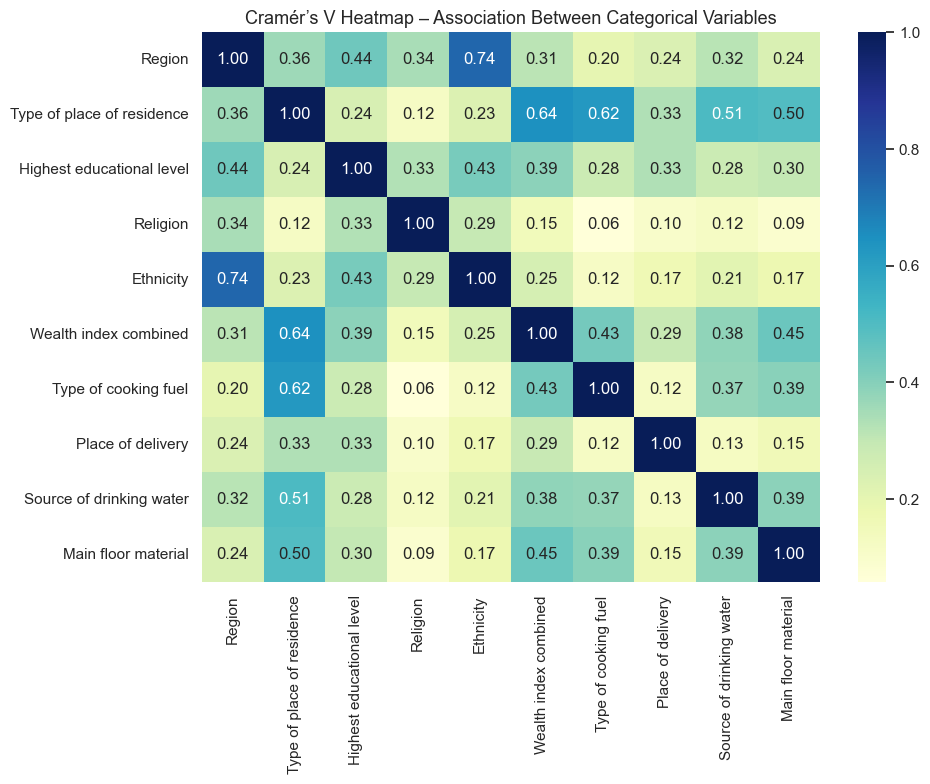

In [695]:
# Cramér’s V Heatmap (Symmetric Associations)
# Select key categorical columns 
cat_cols = [
    'Region',
    'Type of place of residence',
    'Highest educational level',
    'Religion',
    'Ethnicity',
    'Wealth index combined',
    'Type of cooking fuel',
    'Place of delivery',
    'Source of drinking water',
    'Main floor material'
]

# Subset
cat_df = df_eda[cat_cols].copy()

# Define Cramér's V function
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Compute Cramér’s V matrix 
cramers_results = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),
    index=cat_cols, columns=cat_cols
)

for col1 in cat_cols:
    for col2 in cat_cols:
        cramers_results.loc[col1, col2] = cramers_v(cat_df[col1], cat_df[col2])

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_results, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Cramér’s V Heatmap – Association Between Categorical Variables", fontsize=13)
plt.tight_layout()
plt.show()


In [696]:
df = pd.read_pickle('u5mr_dataset.pkl')

int_vars = [
    'Number of household members',
    'Birth order number',
    'Preceding birth interval (months)',
    'Entries in pregnancy and postnatal care roster',
    'Minutes to nearest healthcare facility',
    'Number of tetanus injections before birth',
]

continuous_vars = [
    'Childs weight in kilograms (1 decimal)',
    'Childs height in centimeters (1 decimal)',
    'Height/Age standard deviation (new WHO)',
    'Weight/Age standard deviation (new WHO)',
    'Weight/Height standard deviation (new WHO)'
]  

categorical_vars = [
    'Region',
    'Type of place of residence',
    'Highest educational level',
    'Religion',
    'Ethnicity',
    'Wealth index combined',
    'Type of cooking fuel',
    'Place of delivery',
    'Has health card and or other vaccination document',
    'Place where most vaccinations were received',
    'Currently breastfeeding',
    'In contact with someone with cough or TB',
    'Source of drinking water',
    'Main floor material',
    'Visited health facility last 12 months',
    'Getting medical help for self: distance to health facility',
    'Mode of transportation to nearest healthcare facility',
    'delivery_help',
    'prenatal_help',
    'child_death_history',

    # --- Updated timeliness fields ---
    'BCG_timeliness',
    'POLIO 0_timeliness',
    'POLIO 1_timeliness',
    'POLIO 2_timeliness',
    'POLIO 3_timeliness',
    'Pentavalent 1_timeliness',
    'Pentavalent 2_timeliness',
    'Pentavalent 3_timeliness',
    'Pneumococcal 1_timeliness',
    'Pneumococcal 2_timeliness',
    'Pneumococcal 3_timeliness',
    'Rotavirus 1_timeliness',
    'Rotavirus 2_timeliness',
    'Inactivated polio (IPV)_timeliness',
    'Measles 1_timeliness',
    'Measles 2_timeliness'
    ]

In [608]:
# ==========================
# Association Summary Table
# ==========================

# --- Helper function for Cramér's V ---
def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# -----------------------------
# Continuous Variables
# -----------------------------
results_cont = []
for var in continuous_vars:
    alive = df[df["under5_death"] == 0][var].dropna()
    dead = df[df["under5_death"] == 1][var].dropna()
    
    # Normality check
    _, p_norm_alive = stats.shapiro(alive.sample(min(len(alive), 500), random_state=42))
    _, p_norm_dead = stats.shapiro(dead.sample(min(len(dead), 500), random_state=42))
    
    if p_norm_alive > 0.05 and p_norm_dead > 0.05:
        stat, pval = stats.ttest_ind(alive, dead)
        test_used = "t-test"
        pooled_sd = np.sqrt(((alive.std() ** 2) + (dead.std() ** 2)) / 2)
        effect_size = (alive.mean() - dead.mean()) / pooled_sd
        effect_label = "Cohen's d"
    else:
        stat, pval = stats.mannwhitneyu(alive, dead, alternative="two-sided")
        test_used = "Mann-Whitney U"
        n1, n2 = len(alive), len(dead)
        effect_size = 1 - (2 * stat) / (n1 * n2)  # Rank-biserial correlation
        effect_label = "Rank-biserial r"
    
    # Interpret effect size
    if effect_label == "Cohen's d":
        if abs(effect_size) < 0.2: interpretation = "negligible"
        elif abs(effect_size) < 0.5: interpretation = "small"
        elif abs(effect_size) < 0.8: interpretation = "medium"
        else: interpretation = "large"
    else:  # rank-biserial r
        if abs(effect_size) < 0.1: interpretation = "negligible"
        elif abs(effect_size) < 0.3: interpretation = "small"
        elif abs(effect_size) < 0.5: interpretation = "medium"
        else: interpretation = "large"
    
    results_cont.append([
        var, "Continuous", test_used, round(stat, 3), round(pval, 4),
        effect_label, round(effect_size, 3), interpretation
    ])

df_cont_summary = pd.DataFrame(
    results_cont,
    columns=["Variable", "Type", "Test", "Statistic", "p-value",
             "Effect Size", "Value", "Interpretation"]
)


# -----------------------------
# Categorical Variables
# -----------------------------
results_cat = []
for var in categorical_vars:
    ct = pd.crosstab(df[var], df["under5_death"])
    chi2, p, dof, ex = stats.chi2_contingency(ct)
    effect_size = cramers_v(ct)
    
    # Interpret Cramér's V
    if effect_size < 0.1: interpretation = "negligible"
    elif effect_size < 0.3: interpretation = "small"
    elif effect_size < 0.5: interpretation = "medium"
    else: interpretation = "large"
    
    results_cat.append([
        var, "Categorical", "Chi-square", round(chi2, 3), round(p, 4),
        "Cramér's V", round(effect_size, 3), interpretation
    ])

df_cat_summary = pd.DataFrame(
    results_cat,
    columns=["Variable", "Type", "Test", "Statistic", "p-value",
             "Effect Size", "Value", "Interpretation"]
)


# -----------------------------
# Discrete Numeric Variables
# -----------------------------
results_disc = []
for var in int_vars:
    x = df[var].dropna()
    y = df.loc[x.index, "under5_death"]
    
    corr, pval = stats.pointbiserialr(y, x)
    
    # Interpret correlation
    if abs(corr) < 0.1: interpretation = "negligible"
    elif abs(corr) < 0.3: interpretation = "small"
    elif abs(corr) < 0.5: interpretation = "medium"
    else: interpretation = "large"
    
    results_disc.append([
        var, "Discrete numeric", "Point-biserial r", round(corr, 3), round(pval, 4),
        "Correlation r", round(corr, 3), interpretation
    ])

df_disc_summary = pd.DataFrame(
    results_disc,
    columns=["Variable", "Type", "Test", "Statistic", "p-value",
             "Effect Size", "Value", "Interpretation"]
)


# -----------------------------
# Final Combined Summary
# -----------------------------
summary_table = pd.concat([df_cont_summary, df_cat_summary, df_disc_summary], ignore_index=True)

#Sort by p-value first (ascending), then by effect size (descending for stronger effects)
summary_table = summary_table.sort_values(
    by=["p-value", "Value"], 
    ascending=[True, False]
).reset_index(drop=True)

summary_table


c:\Users\pc\anaconda4\envs\anc-env\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning:

scipy.stats.shapiro: Input data has range zero. The results may not be accurate.



,Variable,Type,Test,Statistic,p-value,Effect Size,Value,Interpretation
0,child_death_history,Categorical,Chi-square,4286.838,0.0000,Cramér's V,0.468,medium
1,Place where most vaccinations were received,Categorical,Chi-square,407.752,0.0000,Cramér's V,0.142,small
2,BCG_timeliness,Categorical,Chi-square,260.772,0.0000,Cramér's V,0.115,small
3,POLIO 1_timeliness,Categorical,Chi-square,242.780,0.0000,Cramér's V,0.111,small
4,Pentavalent 1_timeliness,Categorical,Chi-square,244.629,0.0000,Cramér's V,0.111,small
5,Pneumococcal 1_timeliness,Categorical,Chi-square,241.924,0.0000,Cramér's V,0.111,small
6,POLIO 2_timeliness,Categorical,Chi-square,228.753,0.0000,Cramér's V,0.108,small
7,Pentavalent 2_timeliness,Categorical,Chi-square,231.642,0.0000,Cramér's V,0.108,small
8,Pneumococcal 2_timeliness,Categorical,Chi-square,230.484,0.0000,Cramér's V,0.108,small
9,Rotavirus 1_timeliness,Categorical,Chi-square,223.598,0.0000,Cramér's V,0.106,small


## Feature Selection Summary for Under-5 Mortality Modelling

### Retained Features (Strong / Conditional)

These variables were selected based on statistical significance, effect size, and conceptual relevance.

| Variable | Type | Reason for Inclusion |
|----------|------|--------------------|
| child_death_history | Categorical | Strong association (medium Cramér's V = 0.468) |
| Place where most vaccinations were received | Categorical | Small association (Cramér's V = 0.142); represents health service access |
| BCG_timeliness | Categorical | Small association; key vaccination indicator |
| POLIO 1_timeliness | Categorical | Small association; immunization coverage |
| POLIO 2_timeliness | Categorical | Small association |
| POLIO 3_timeliness | Categorical | Small association |
| Pentavalent 1_timeliness | Categorical | Small association |
| Pentavalent 2_timeliness | Categorical | Small association |
| Pentavalent 3_timeliness | Categorical | Small association |
| Pneumococcal 1_timeliness | Categorical | Small association |
| Pneumococcal 2_timeliness | Categorical | Small association |
| Pneumococcal 3_timeliness | Categorical | Small association |
| Rotavirus 1_timeliness | Categorical | Small association |
| Rotavirus 2_timeliness | Categorical | Small association |
| Measles 1_timeliness | Categorical | Small association |
| Inactivated polio (IPV)_timeliness | Categorical | Small association |
| Has health card and or other vaccination document | Categorical | Negligible but conceptually important |
| Currently breastfeeding | Categorical | Negligible but relevant to child survival |
| Entries in pregnancy and postnatal care roster | Numeric | Negligible but relevant to maternal care |
| Highest educational level | Categorical | Conditional predictor; socio-economic proxy |
| Place of delivery | Categorical | Conditional predictor; health service proxy |
| Region | Categorical | Conditional predictor; geographic context |
| Wealth index combined | Categorical | Conditional predictor; socio-economic status |
| Type of place of residence | Categorical | Conditional predictor; urban/rural differences |
| Number of household members | Numeric | Conditional predictor; household size effects |
| Birth order number | Numeric | Conditional predictor; higher parity risks |
| Preceding birth interval (months) | Numeric | Conditional predictor; spacing impacts survival |

---

### Rejected Features

These variables were not retained due to negligible association or redundancy.

| Variable | Type | Reason for Rejection |
|----------|------|--------------------|
| Religion | Categorical | Not significant after adjusting for education and wealth |
| Mode of transportation to nearest healthcare facility | Categorical | Weak association; high missingness |
| Type of cooking fuel | Categorical | Weak predictor; confounded by wealth/residence |
| Main floor material | Categorical | Low variation; overlaps with wealth index |
| Source of drinking water | Categorical | Weak effect; redundant with residence/wealth |
| Minutes to nearest healthcare facility | Numeric | Missing data; not significant |
| Childs age in months | Numeric | Either constant at birth or outside mortality window |
| Any vaccine timeliness variables not listed above | Categorical | Negligible association; sparse data |
| Delivery_help / prenatal_help | Categorical | Negligible association |
| Ethnicity | Categorical | Negligible association |
| Visited health facility last 12 months | Categorical | Negligible association |
| Type of cooking fuel | Categorical | Negligible association |

---

**Notes:**

1. “Strong / Core predictors” are prioritized due to effect size (medium or small Cramér's V) and conceptual relevance.  
2. “Conditional / Contextual predictors” are included for context or potential interactions.  
3. Rejected variables may still be useful for exploratory analysis but are omitted in the main predictive model.  


## <center>Modelling

In [703]:
df = pd.read_pickle('u5mr_dataset.pkl')
df.head()

,CASEID,Respondents current age,Region,Type of place of residence,Highest educational level,Religion,Ethnicity,Number of household members,Wealth index combined,Type of cooking fuel,...,POLIO 2_timeliness,Pentavalent 2_timeliness,Pneumococcal 2_timeliness,Rotavirus 2_timeliness,POLIO 3_timeliness,Pentavalent 3_timeliness,Pneumococcal 3_timeliness,Inactivated polio (IPV)_timeliness,Measles 1_timeliness,Measles 2_timeliness
0,1 4 2,34.0,Mombasa,Urban,No education,Islam,Somali,4,Richer,LPG,...,on_time,on_time,on_time,on_time,on_time,on_time,on_time,on_time,missing,missing
1,1 13 2,39.0,Mombasa,Urban,Secondary,Catholic,Kamba,4,Richest,LPG,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
2,1 26 2,28.0,Mombasa,Urban,Secondary,Evangelical churches,Kamba,5,Richer,LPG,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
3,1 42 1,30.0,Mombasa,Urban,Secondary,African instituted churches,Kamba,3,Richest,LPG,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
4,1 55 2,34.0,Mombasa,Urban,Secondary,Protestant,Kamba,4,Richest,LPG,...,on_time,missing,on_time,on_time,on_time,missing,on_time,on_time,missing,missing


In [704]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19530 entries, 0 to 19529
Data columns (total 55 columns):
 #   Column                                                      Non-Null Count  Dtype   
---  ------                                                      --------------  -----   
 0   CASEID                                                      19530 non-null  object  
 1   Respondents current age                                     19530 non-null  float64 
 2   Region                                                      19530 non-null  category
 3   Type of place of residence                                  19530 non-null  category
 4   Highest educational level                                   19530 non-null  category
 5   Religion                                                    19530 non-null  category
 6   Ethnicity                                                   19530 non-null  category
 7   Number of household members                                 19530 non-null  

In [705]:
df_mod = df[['child_death_history',
    'Place where most vaccinations were received',
    'BCG_timeliness',
    'POLIO 1_timeliness',
    'Pentavalent 1_timeliness',
    'Pneumococcal 1_timeliness',
    'POLIO 2_timeliness',
    'Pentavalent 2_timeliness',
    'Pneumococcal 2_timeliness',
    'Rotavirus 1_timeliness',
    'Pentavalent 3_timeliness',
    'POLIO 3_timeliness',
    'Pneumococcal 3_timeliness',
    'Rotavirus 2_timeliness',
    'POLIO 0_timeliness',
    'Inactivated polio (IPV)_timeliness',
    'Currently breastfeeding',
    'Measles 1_timeliness',
    'Entries in pregnancy and postnatal care roster',
    'Measles 2_timeliness',
    'Number of household members',
    'Place of delivery',
    'Highest educational level',
    'prenatal_help',
    'Region',
    'under5_death']]

# Save full dataframe
with open("u5mr_modelling.pkl", "wb") as f:
    pickle.dump(df_mod, f)

print(f"Saved essential subset with {df_mod.shape[1]} variables and {df_mod.shape[0]} rows.")

Saved essential subset with 26 variables and 19530 rows.


In [2]:
import pandas as pd
df = pd.read_pickle("u5mr_modelling.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19530 entries, 0 to 19529
Data columns (total 26 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   child_death_history                             19530 non-null  category
 1   Place where most vaccinations were received     19530 non-null  category
 2   BCG_timeliness                                  19530 non-null  category
 3   POLIO 1_timeliness                              19530 non-null  category
 4   Pentavalent 1_timeliness                        19530 non-null  category
 5   Pneumococcal 1_timeliness                       19530 non-null  category
 6   POLIO 2_timeliness                              19530 non-null  category
 7   Pentavalent 2_timeliness                        19530 non-null  category
 8   Pneumococcal 2_timeliness                       19530 non-null  category
 9   Rotavirus 1_timeliness      

In [710]:
target = df["under5_death"]
target.value_counts()

under5_death
0    18836
1      694
Name: count, dtype: int64

In [ ]:
# # =========================================
# # XGBOOST MODEL (IMBALANCED DATA + CUSTOM F2 SCORER)
# # =========================================

# import pandas as pd
# import numpy as np
# import joblib
# import json
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import (
#     fbeta_score, confusion_matrix, accuracy_score,
#     precision_recall_curve, classification_report, make_scorer
# )
# from xgboost import XGBClassifier

# # -------------------------------
# # 1️⃣ Load dataset
# # -------------------------------
# df = pd.read_pickle("u5mr_modelling.pkl")
# target = "under5_death"
# X = df.drop(columns=[target])
# y = df[target]

# # -------------------------------
# # 2️⃣ Split data
# # -------------------------------
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# # -------------------------------
# # 3️⃣ Preprocessing
# # -------------------------------
# numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
# categorical_features = X_train.select_dtypes(include=["category", "object"]).columns.tolist()

# numeric_transformer = Pipeline([("scaler", StandardScaler())])
# categorical_transformer = Pipeline([
#     ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
# ])

# preprocessor = ColumnTransformer([
#     ("num", numeric_transformer, numeric_features),
#     ("cat", categorical_transformer, categorical_features)
# ])

# # -------------------------------
# # 4️⃣ Compute class weight
# # -------------------------------
# neg, pos = np.bincount(y_train)
# scale_pos_weight = neg / pos
# print(f"Class imbalance ratio: {scale_pos_weight:.2f}")

# # -------------------------------
# # 5️⃣ XGBoost base model
# # -------------------------------
# xgb = XGBClassifier(
#     objective="binary:logistic",
#     eval_metric="logloss",
#     use_label_encoder=False,
#     random_state=42,
#     n_jobs=-1,
#     tree_method="hist",
#     scale_pos_weight=scale_pos_weight
# )

# # -------------------------------
# # 6️⃣ Randomized search space
# # -------------------------------
# param_dist = {
#     "xgb__n_estimators": [300, 500, 700],
#     "xgb__max_depth": [4, 6, 8],
#     "xgb__learning_rate": [0.01, 0.05, 0.1],
#     "xgb__subsample": [0.7, 0.8, 1.0],
#     "xgb__colsample_bytree": [0.7, 0.8, 1.0],
#     "xgb__gamma": [0, 0.5, 1],
#     "xgb__min_child_weight": [1, 3, 5],
# }

# pipeline = Pipeline([
#     ("preprocessor", preprocessor),
#     ("xgb", xgb)
# ])

# # ✅ Custom F2 scorer
# f2_scorer = make_scorer(fbeta_score, beta=2)

# # -------------------------------
# # 7️⃣ RandomizedSearchCV
# # -------------------------------
# search = RandomizedSearchCV(
#     pipeline,
#     param_distributions=param_dist,
#     n_iter=20,
#     scoring=f2_scorer,
#     cv=3,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# search.fit(X_train, y_train)
# best_model = search.best_estimator_

# print("\n✅ Best parameters found:")
# print(search.best_params_)

# # -------------------------------
# # 8️⃣ Predict + Threshold Optimization
# # -------------------------------
# y_proba = best_model.predict_proba(X_test)[:, 1]
# prec, rec, thresh = precision_recall_curve(y_test, y_proba)
# f2_scores = [fbeta_score(y_test, (y_proba >= t).astype(int), beta=2) for t in thresh]
# best_threshold = thresh[np.argmax(f2_scores)]

# print(f"\n✅ Best F2 Threshold: {best_threshold:.4f}")

# y_pred = (y_proba >= best_threshold).astype(int)

# # -------------------------------
# # 9️⃣ Evaluate
# # -------------------------------
# conf_matrix = confusion_matrix(y_test, y_pred)
# f2 = fbeta_score(y_test, y_pred, beta=2)
# accuracy = accuracy_score(y_test, y_pred)

# print("\nConfusion Matrix:\n", conf_matrix)
# print(f"F2 Score: {f2:.4f}")
# print(f"Accuracy: {accuracy:.4f}")
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# # -------------------------------
# # 🔟 Save
# # -------------------------------
# joblib.dump(best_model, "xgb_best_model.pkl")
# json.dump({"best_threshold": float(best_threshold)}, open("threshold.json", "w"))
# print("\n✅ Model, threshold, and parameters saved successfully.")


Class imbalance ratio: 27.15
Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\pc\anaconda4\envs\anc-env\lib\site-packages\xgboost\training.py:183: UserWarning:

[19:23:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.





✅ Best parameters found:
{'xgb__subsample': 0.8, 'xgb__n_estimators': 700, 'xgb__min_child_weight': 5, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 1, 'xgb__colsample_bytree': 0.8}

✅ Best F2 Threshold: 0.8510

Confusion Matrix:
 [[3618  149]
 [  13  126]]
F2 Score: 0.7581
Accuracy: 0.9585

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      3767
           1       0.46      0.91      0.61       139

    accuracy                           0.96      3906
   macro avg       0.73      0.93      0.79      3906
weighted avg       0.98      0.96      0.96      3906


✅ Model, threshold, and parameters saved successfully.


In [714]:
# Iterate through each column and print its value counts
for column in df.columns:
    print(f"Value counts for column '{column}':")
    print(df[column].value_counts())
    print("-" * 30) # Separator for readability

Value counts for column 'child_death_history':
child_death_history
0    16727
1     2803
Name: count, dtype: int64
------------------------------
Value counts for column 'Place where most vaccinations were received':
Place where most vaccinations were received
Government dispensary                          12466
Government hospital                             3544
Government health center                        2150
Private hospital                                 703
FBO/mission hospital                             282
Private clinic                                   189
Mobile clinic                                     72
FBO/mission clinic                                38
Community health worker/fieldworker               25
NGO hospital                                      18
FBO mobile clinic                                 13
Vaccination campaign                              13
Pharmacy                                           7
NGO clinic                                        

In [ ]:
# sample_low = {
#     "child_death_history": 0,
#     "Place where most vaccinations were received": "Government dispensary",
#     "BCG_timeliness": "on_time",
#     "POLIO 1_timeliness": "on_time",
#     "Pentavalent 1_timeliness": "on_time",
#     "Pneumococcal 1_timeliness": "on_time",
#     "POLIO 2_timeliness": "on_time",
#     "Pentavalent 2_timeliness": "on_time",
#     "Pneumococcal 2_timeliness": "on_time",
#     "Rotavirus 1_timeliness": "on_time",
#     "Pentavalent 3_timeliness": "on_time",
#     "POLIO 3_timeliness": "on_time",
#     "Pneumococcal 3_timeliness": "on_time",
#     "Rotavirus 2_timeliness": "on_time",
#     "POLIO 0_timeliness": "on_time",
#     "Inactivated polio (IPV)_timeliness": "on_time",
#     "Currently breastfeeding": "Yes",
#     "Measles 1_timeliness": "on_time",
#     "Entries in pregnancy and postnatal care roster": 3,
#     "Measles 2_timeliness": "on_time",
#     "Number of household members": 4,
#     "Place of delivery": "Government hospital",
#     "Highest educational level": "Secondary",
#     "prenatal_help": "Skilled",
#     "Region": "Kiambu",
# }

# sample_high = {
#     "child_death_history": 1,
#     "Place where most vaccinations were received": "Community health worker/fieldworker",
#     "BCG_timeliness": "missing",
#     "POLIO 1_timeliness": "missing",
#     "Pentavalent 1_timeliness": "missing",
#     "Pneumococcal 1_timeliness": "missing",
#     "POLIO 2_timeliness": "missing",
#     "Pentavalent 2_timeliness": "missing",
#     "Pneumococcal 2_timeliness": "missing",
#     "Rotavirus 1_timeliness": "missing",
#     "Pentavalent 3_timeliness": "missing",
#     "POLIO 3_timeliness": "missing",
#     "Pneumococcal 3_timeliness": "missing",
#     "Rotavirus 2_timeliness": "missing",
#     "POLIO 0_timeliness": "missing",
#     "Inactivated polio (IPV)_timeliness": "missing",
#     "Currently breastfeeding": "No",
#     "Measles 1_timeliness": "missing",
#     "Entries in pregnancy and postnatal care roster": 0,
#     "Measles 2_timeliness": "missing",
#     "Number of household members": 12,
#     "Place of delivery": "Respondent's home",
#     "Highest educational level": "No education",
#     "prenatal_help": "Unskilled",
#     "Region": "Mandera",
# }


In [ ]:
# import pandas as pd
# import joblib, json

# # 1️⃣ Load the trained model and best threshold
# model = joblib.load("xgb_best_model.pkl")

# with open("threshold.json") as f:
#     threshold = json.load(f)["best_threshold"]

# # 3️⃣ Convert to DataFrame for model input
# df_test = pd.DataFrame([sample_low, sample_high])

# # 4️⃣ Get predicted probabilities and binary predictions
# probs = model.predict_proba(df_test)[:, 1]
# preds = (probs >= threshold).astype(int)

# # 5️⃣ Display results
# for i, label in enumerate(["Low-Risk Case", "High-Risk Case"]):
#     print(f"\n🧩 {label}")
#     print(f"Predicted probability of under-5 death: {probs[i]:.4f}")
#     print(f"Predicted class (>= {threshold:.3f}): {preds[i]}")


🧩 Low-Risk Case
Predicted probability of under-5 death: 0.0005
Predicted class (>= 0.851): 0

🧩 High-Risk Case
Predicted probability of under-5 death: 0.0259
Predicted class (>= 0.851): 0


In [ ]:
# import pandas as pd
# import joblib, json

# # Load model and threshold
# model = joblib.load("xgb_best_model.pkl")
# with open("threshold.json") as f:
#     threshold = json.load(f)["best_threshold"]

# # 🧠 Risk level function
# def get_risk_category(prob):
#     if prob < 0.2:
#         return "Low", "Child has very low predicted risk of under-5 death."
#     elif prob < 0.5:
#         return "Moderate", "Some potential risk factors present, but not severe."
#     elif prob < threshold:
#         return "High", "Elevated risk detected; attention recommended."
#     else:
#         return "Critical", "Very high risk of under-5 death — urgent intervention suggested."

# # 🧩 Sample test cases
# df_test = pd.DataFrame([sample_low, sample_high])
# probs = model.predict_proba(df_test)[:, 1]
# preds = (probs >= threshold).astype(int)

# # 💬 Output results
# for i, label in enumerate(["Low-Risk Case", "High-Risk Case"]):
#     risk_level, explanation = get_risk_category(probs[i])
#     print(f"\n🧩 {label}")
#     print(f"Predicted probability of under-5 death: {probs[i]:.4f}")
#     print(f"Predicted class (>= {threshold:.3f}): {preds[i]}")
#     print(f"⚖️ Risk Level: {risk_level}")
#     print(f"🩺 {explanation}")



🧩 Low-Risk Case
Predicted probability of under-5 death: 0.0005
Predicted class (>= 0.851): 0
⚖️ Risk Level: Low
🩺 Child has very low predicted risk of under-5 death.

🧩 High-Risk Case
Predicted probability of under-5 death: 0.0259
Predicted class (>= 0.851): 0
⚖️ Risk Level: Low
🩺 Child has very low predicted risk of under-5 death.


In [3]:
# =========================================
# XGBOOST MODEL (IMBALANCED DATA + CUSTOM F2 SCORER)
# =========================================

import pandas as pd
import numpy as np
import joblib
import json
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    fbeta_score, confusion_matrix, accuracy_score,
    precision_recall_curve, classification_report
)
from xgboost import XGBClassifier

# -------------------------------
# 1️⃣ Load dataset
# -------------------------------
df = pd.read_pickle("u5mr_modelling.pkl")
target = "under5_death"
X = df.drop(columns=[target])
y = df[target]

# -------------------------------
# 2️⃣ Split data
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

joblib.dump(X_test, "X_test.pkl")
joblib.dump(y_test, "y_test.pkl")
print("💾 Test data saved as X_test.pkl and y_test.pkl")

# -------------------------------
# 3️⃣ Preprocessing
# -------------------------------
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["category", "object"]).columns.tolist()

numeric_transformer = Pipeline([("scaler", StandardScaler())])
categorical_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# -------------------------------
# 4️⃣ Compute class weight
# -------------------------------
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"Class imbalance ratio: {scale_pos_weight:.2f}")

# -------------------------------
# 5️⃣ Final XGBoost model with best params
# -------------------------------
best_params = {
    "n_estimators": 700,
    "max_depth": 8,
    "learning_rate": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "gamma": 1,
    "min_child_weight": 5,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "random_state": 42,
    "n_jobs": -1,
    "tree_method": "hist",
    "scale_pos_weight": scale_pos_weight,
}

xgb = XGBClassifier(**best_params)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("xgb", xgb)
])

# -------------------------------
# 6️⃣ Train model directly
# -------------------------------
pipeline.fit(X_train, y_train)

# -------------------------------
# 7️⃣ Predict + Threshold Optimization
# -------------------------------
y_proba = pipeline.predict_proba(X_test)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, y_proba)
f2_scores = [fbeta_score(y_test, (y_proba >= t).astype(int), beta=2) for t in thresh]
best_threshold = thresh[np.argmax(f2_scores)]
print(f"\n✅ Best F2 Threshold: {best_threshold:.4f}")

y_pred = (y_proba >= best_threshold).astype(int)

# -------------------------------
# 8️⃣ Evaluate
# -------------------------------
conf_matrix = confusion_matrix(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)
accuracy = accuracy_score(y_test, y_pred)

print("\nConfusion Matrix:\n", conf_matrix)
print(f"F2 Score: {f2:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# -------------------------------
# 9️⃣ Save model + threshold
# -------------------------------
joblib.dump(pipeline, "xgb_best_model.pkl")
json.dump({"best_threshold": float(best_threshold)}, open("threshold.json", "w"))
print("\n✅ Final model and threshold saved successfully.")

💾 Test data saved as X_test.pkl and y_test.pkl
Class imbalance ratio: 27.15


c:\Users\pc\Documents\Moringa\Phase5\Under5\venv\lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):



✅ Best F2 Threshold: 0.8574

Confusion Matrix:
 [[3619  148]
 [  14  125]]
F2 Score: 0.7539
Accuracy: 0.9585

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      3767
           1       0.46      0.90      0.61       139

    accuracy                           0.96      3906
   macro avg       0.73      0.93      0.79      3906
weighted avg       0.98      0.96      0.96      3906


✅ Final model and threshold saved successfully.


📦 Loading model and test data...
🔮 Generating probabilities...
⚙️ Searching best F2 threshold...

✅ Best F2 Score: 0.7543
🎯 Optimal Threshold: 0.8593

💾 Threshold saved to threshold.json


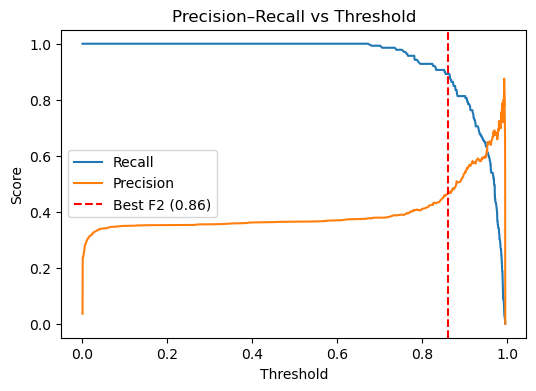


🧠 Sample test:

🧩 Low-Risk Case
Predicted probability of under-5 death: 0.0005
⚖️ Risk Level: Low
🩺 Child has a very low predicted risk of under-5 death.

🧩 High-Risk Case
Predicted probability of under-5 death: 0.0259
⚖️ Risk Level: Low
🩺 Child has a very low predicted risk of under-5 death.


In [5]:
import numpy as np
import pandas as pd
import joblib, json
from sklearn.metrics import fbeta_score, precision_recall_curve
import matplotlib.pyplot as plt

# 1️⃣ Load trained model and test data
print("📦 Loading model and test data...")
model = joblib.load("xgb_best_model.pkl")

# Replace with your actual data paths or variable names
X_test = joblib.load("X_test.pkl")
y_test = joblib.load("y_test.pkl")

# 2️⃣ Get predicted probabilities
print("🔮 Generating probabilities...")
y_probs = model.predict_proba(X_test)[:, 1]

# 3️⃣ Search for best F2 threshold
print("⚙️ Searching best F2 threshold...")
best_threshold, best_f2 = 0, 0
thresholds = np.linspace(0, 1, 200)

for t in thresholds:
    preds = (y_probs >= t).astype(int)
    f2 = fbeta_score(y_test, preds, beta=2)
    if f2 > best_f2:
        best_f2, best_threshold = f2, t

print(f"\n✅ Best F2 Score: {best_f2:.4f}")
print(f"🎯 Optimal Threshold: {best_threshold:.4f}")

# 4️⃣ Define dynamic risk categories
def get_risk_level(prob, high_thr):
    if prob < 0.25 * high_thr:
        return "Low"
    elif prob < high_thr:
        return "Medium"
    else:
        return "High"

# 5️⃣ Save the updated threshold
json.dump({"best_threshold": float(best_threshold)}, open("threshold.json", "w"))
print("\n💾 Threshold saved to threshold.json")

# 6️⃣ Visualize Precision-Recall tradeoff
precision, recall, thres = precision_recall_curve(y_test, y_probs)
plt.figure(figsize=(6,4))
plt.plot(thres, recall[:-1], label="Recall")
plt.plot(thres, precision[:-1], label="Precision")
plt.axvline(best_threshold, color="r", linestyle="--", label=f"Best F2 ({best_threshold:.2f})")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision–Recall vs Threshold")
plt.show()

# 7️⃣ Test on example cases
print("\n🧠 Sample test:")
sample_low = {"child_death_history": 0, "Place where most vaccinations were received": "Government dispensary",
              "BCG_timeliness": "on_time", "POLIO 1_timeliness": "on_time", "Pentavalent 1_timeliness": "on_time",
              "Pneumococcal 1_timeliness": "on_time", "POLIO 2_timeliness": "on_time", "Pentavalent 2_timeliness": "on_time",
              "Pneumococcal 2_timeliness": "on_time", "Rotavirus 1_timeliness": "on_time", "Pentavalent 3_timeliness": "on_time",
              "POLIO 3_timeliness": "on_time", "Pneumococcal 3_timeliness": "on_time", "Rotavirus 2_timeliness": "on_time",
              "POLIO 0_timeliness": "on_time", "Inactivated polio (IPV)_timeliness": "on_time", "Currently breastfeeding": "Yes",
              "Measles 1_timeliness": "on_time", "Entries in pregnancy and postnatal care roster": 2, "Measles 2_timeliness": "on_time",
              "Number of household members": 4, "Place of delivery": "Government hospital", "Highest educational level": "Higher",
              "prenatal_help": "Skilled", "Region": "Nairobi"}

sample_high = {"child_death_history": 1, "Place where most vaccinations were received": "Community health worker/fieldworker",
               "BCG_timeliness": "missing", "POLIO 1_timeliness": "missing", "Pentavalent 1_timeliness": "missing",
               "Pneumococcal 1_timeliness": "missing", "POLIO 2_timeliness": "missing", "Pentavalent 2_timeliness": "missing",
               "Pneumococcal 2_timeliness": "missing", "Rotavirus 1_timeliness": "missing", "Pentavalent 3_timeliness": "missing",
               "POLIO 3_timeliness": "missing", "Pneumococcal 3_timeliness": "missing", "Rotavirus 2_timeliness": "missing",
               "POLIO 0_timeliness": "missing", "Inactivated polio (IPV)_timeliness": "missing", "Currently breastfeeding": "No",
               "Measles 1_timeliness": "missing", "Entries in pregnancy and postnatal care roster": 0, "Measles 2_timeliness": "missing",
               "Number of household members": 12, "Place of delivery": "Respondent's home", "Highest educational level": "No education",
               "prenatal_help": "Unskilled", "Region": "Mandera"}

df_test = pd.DataFrame([sample_low, sample_high])
probs = model.predict_proba(df_test)[:, 1]

for i, (case, label) in enumerate(zip([sample_low, sample_high], ["Low-Risk Case", "High-Risk Case"])):
    risk = get_risk_level(probs[i], best_threshold)
    print(f"\n🧩 {label}")
    print(f"Predicted probability of under-5 death: {probs[i]:.4f}")
    print(f"⚖️ Risk Level: {risk}")
    if risk == "Low":
        print("🩺 Child has a very low predicted risk of under-5 death.")
    elif risk == "Medium":
        print("⚠️ Child shows moderate indicators of risk — further monitoring advised.")
    else:
        print("🚨 High predicted risk of under-5 death — immediate intervention recommended.")
